In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

# Imports

In [2]:
import GPy, GPyOpt
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from rdkit import Chem
from sklearn.feature_selection import VarianceThreshold

from src import models
from src import experimental_setup
from src.helpers import create_morgan_space

# Experimental setup

In [3]:
# these don't really matter since inputs need to be generated on the fly (ECFP nbits and radius tuning)
identity = 'dnn_ecfp'
encoding = 'mordred'

kfold = experimental_setup.CrossValidator(
    splits = 5,
    sampling_type = 'random',
)

# Define search region

bounds = [
    {'name': "learning_rate", 'type': 'continuous', 'domain': (0.0001,0.1)},
    {'name': "n_layers",      'type': 'discrete',   'domain': range(1,6)},
    {'name': 'layer_size',    'type': 'discrete',   'domain': [32,64,128,256,512,1024,2048,4096]},
    {'name': 'batch_size',    'type': 'discrete',   'domain': [32,64,128,256,512,1024,2048,4096]},
    {'name': 'nbits',         'type': 'discrete',   'domain': [128,256,512,1024,2048,4096]},
    {'name': 'radius',        'type': 'discrete',   'domain': range(1,9)}
]

# Optimization candidate

In [5]:
# globally referenced in search; remain calm
best = {'score': np.inf, 'history': None}

def search(x):
    errors = []
    
    featurizer = create_morgan_space(r=int(x[:,5]), nbits=int(x[:,4]))
    col_selector = VarianceThreshold()
    
    for fold_no, (train, test) in enumerate(kfold.get_folds(encoding)):
        x_train, y_train, smiles_train = train
        x_test, y_test, smiles_test = test
        
        y_train = experimental_setup.scaler.fit_transform(y_train)
        y_test = experimental_setup.scaler.transform(y_test)
        
        # need to re-generate fingerprints for every trial
        x_train = col_selector.fit_transform(np.array([np.array(featurizer(Chem.MolFromSmiles(smi))) for smi in smiles_train.squeeze()]).astype(np.float32))
        x_test = col_selector.transform(np.array([np.array(featurizer(Chem.MolFromSmiles(smi))) for smi in smiles_test.squeeze()]).astype(np.float32))
        
        model = models.DNN()
        
        model.learning_rate = float(x[:,0])
        model.n_layers = int(x[:,1])
        model.layer_size = int(x[:,2])
        model.batch_size = int(x[:,3])
        model.epochs = 3000
        
        early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                                                          monitor='val_loss',
                                                          mode='min',
                                                          restore_best_weights=True)
        
        model.fit(x_train.astype(np.float32), y_train,
                  callbacks=[early_stopping],
                  validation_data=(x_test.astype(np.float32), y_test),
                  verbose=1)
        
        y_hat = experimental_setup.scaler.inverse_transform(model.predict(x_test))
        y_test = experimental_setup.scaler.inverse_transform(y_test)
        
        errors.append( mean_absolute_error(y_test.flatten(), y_hat.flatten()) )
        
    score = np.mean(errors)
    
    # save model for final fold if score is best
    global best
    
    if score < best['score']:
        best['score'] = score
        best['history'] = model.history
    
    print('Avg. MAE: %f' % score)    
    
    return score

# Tune

In [6]:
print("Begin processing!")

np.random.seed(9700)
optimizer = GPyOpt.methods.BayesianOptimization(f=search, domain=bounds,
                model_type='GP',
                acquisition_type ='EI',
                acquisition_jitter = 0.05,
                exact_feval = True,
                num_cores = 40, # Adjust 
                maximize = False,
                verbosity = True)

print("Starting Optimizer!")
optimizer.run_optimization(max_iter=40)

print("Finished Optimization!")

Begin processing!
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 6s 530us/sample - loss: 1.7641 - mse: 1.7641 - mae: 0.8788 - val_loss: 5.1330 - val_mse: 5.1330 - val_mae: 2.0945
Epoch 2/3000
10663/10663 [==============================] - 1s 117us/sample - loss: 0.5067 - mse: 0.5067 - mae: 0.5345 - val_loss: 1.5614 - val_mse: 1.5614 - val_mae: 0.9697
Epoch 3/3000
10663/10663 [==============================] - 1s 112us/sample - loss: 0.4044 - mse: 0.4044 - mae: 0.4772 - val_loss: 1.3402 - val_mse: 1.3402 - val_mae: 0.8513
Epoch 4/3000
10663/10663 [==============================] - 1s 118us/sample - loss: 0.3376 - mse: 0.3376 - mae: 0.4368 - val_loss: 1.1303 - val_mse: 1.1303 - val_mae: 0.7502
Epoch 5/3000
10663/10663 [==============================] - 1s 118us/sample - loss: 0.2530 - mse: 0.2530 - mae: 0.3796 - val_loss: 1.0429 - val_mse: 1.0429 - val_mae: 0.7377
Epoch 6/3000
10663/10663 [==============================] - 1s 

Epoch 10/3000
10663/10663 [==============================] - ETA: 0s - loss: 0.1404 - mse: 0.1404 - mae: 0.285 - 1s 117us/sample - loss: 0.1403 - mse: 0.1403 - mae: 0.2855 - val_loss: 0.5383 - val_mse: 0.5383 - val_mae: 0.5388
Epoch 11/3000
10663/10663 [==============================] - 1s 109us/sample - loss: 0.1183 - mse: 0.1183 - mae: 0.2562 - val_loss: 0.5107 - val_mse: 0.5107 - val_mae: 0.5201
Epoch 12/3000
10663/10663 [==============================] - 1s 116us/sample - loss: 0.1016 - mse: 0.1016 - mae: 0.2404 - val_loss: 0.4988 - val_mse: 0.4988 - val_mae: 0.5160
Epoch 13/3000
10663/10663 [==============================] - 1s 112us/sample - loss: 0.0971 - mse: 0.0971 - mae: 0.2340 - val_loss: 0.5580 - val_mse: 0.5580 - val_mae: 0.5294
Epoch 14/3000
10663/10663 [==============================] - 1s 115us/sample - loss: 0.0935 - mse: 0.0935 - mae: 0.2313 - val_loss: 0.5523 - val_mse: 0.5523 - val_mae: 0.5190
Epoch 15/3000
10663/10663 [==============================] - 1s 111us/sam

10664/10664 [==============================] - 1s 116us/sample - loss: 0.1292 - mse: 0.1292 - mae: 0.2704 - val_loss: 0.5200 - val_mse: 0.5200 - val_mae: 0.5294
Epoch 11/3000
10664/10664 [==============================] - 1s 114us/sample - loss: 0.1311 - mse: 0.1311 - mae: 0.2713 - val_loss: 0.4925 - val_mse: 0.4925 - val_mae: 0.5072
Epoch 12/3000
10664/10664 [==============================] - 1s 117us/sample - loss: 0.1067 - mse: 0.1067 - mae: 0.2458 - val_loss: 0.5516 - val_mse: 0.5516 - val_mae: 0.5371
Epoch 13/3000
10664/10664 [==============================] - 1s 114us/sample - loss: 0.1008 - mse: 0.1008 - mae: 0.2415 - val_loss: 0.5038 - val_mse: 0.5038 - val_mae: 0.5004
Epoch 14/3000
10664/10664 [==============================] - 1s 113us/sample - loss: 0.0956 - mse: 0.0956 - mae: 0.2326 - val_loss: 0.4816 - val_mse: 0.4816 - val_mae: 0.4931
Epoch 15/3000
10664/10664 [==============================] - 1s 119us/sample - loss: 0.0885 - mse: 0.0885 - mae: 0.2233 - val_loss: 0.4691 

Epoch 30/3000
10663/10663 [==============================] - 48s 4ms/sample - loss: 1.4993 - mse: 1.4993 - mae: 0.9566 - val_loss: 42.9080 - val_mse: 42.9080 - val_mae: 6.3415
Epoch 31/3000
10663/10663 [==============================] - 48s 4ms/sample - loss: 1.4752 - mse: 1.4752 - mae: 0.9197 - val_loss: 58.4230 - val_mse: 58.4230 - val_mae: 7.4998
Epoch 32/3000
10663/10663 [==============================] - 48s 4ms/sample - loss: 1.5280 - mse: 1.5280 - mae: 0.9707 - val_loss: 46.7270 - val_mse: 46.7270 - val_mae: 6.7075
Epoch 33/3000
10663/10663 [==============================] - 48s 4ms/sample - loss: 1.4884 - mse: 1.4884 - mae: 0.9265 - val_loss: 65.4674 - val_mse: 65.4674 - val_mae: 8.0010
Epoch 34/3000
10663/10663 [==============================] - 48s 4ms/sample - loss: 1.4271 - mse: 1.4271 - mae: 0.9395 - val_loss: 60.9830 - val_mse: 60.9830 - val_mae: 7.7274
Epoch 35/3000
10663/10663 [==============================] - 48s 4ms/sample - loss: 1.3467 - mse: 1.3467 - mae: 0.8727 -

10663/10663 [==============================] - 48s 5ms/sample - loss: 1.0820 - mse: 1.0820 - mae: 0.7799 - val_loss: 14.9827 - val_mse: 14.9827 - val_mae: 3.6654
Epoch 54/3000
10663/10663 [==============================] - 48s 4ms/sample - loss: 1.0797 - mse: 1.0797 - mae: 0.7999 - val_loss: 12.7057 - val_mse: 12.7057 - val_mae: 3.3523
Epoch 55/3000
10663/10663 [==============================] - 48s 4ms/sample - loss: 1.0592 - mse: 1.0592 - mae: 0.7776 - val_loss: 12.9007 - val_mse: 12.9007 - val_mae: 3.3814
Epoch 56/3000
10663/10663 [==============================] - 48s 4ms/sample - loss: 1.0442 - mse: 1.0442 - mae: 0.7745 - val_loss: 11.8095 - val_mse: 11.8095 - val_mae: 3.2262
Epoch 57/3000
10663/10663 [==============================] - 48s 5ms/sample - loss: 1.0638 - mse: 1.0638 - mae: 0.7884 - val_loss: 10.5116 - val_mse: 10.5116 - val_mae: 3.0390
Epoch 58/3000
10663/10663 [==============================] - 48s 5ms/sample - loss: 1.0744 - mse: 1.0744 - mae: 0.7856 - val_loss: 11.

Epoch 6/3000
10663/10663 [==============================] - 48s 4ms/sample - loss: 331.6747 - mse: 331.6747 - mae: 15.3535 - val_loss: 8820692.0000 - val_mse: 8820692.0000 - val_mae: 2858.9075
Epoch 7/3000
10663/10663 [==============================] - 48s 4ms/sample - loss: 213.8503 - mse: 213.8503 - mae: 11.3065 - val_loss: 1921454.6250 - val_mse: 1921454.6250 - val_mae: 1280.8684
Epoch 8/3000
10663/10663 [==============================] - 48s 4ms/sample - loss: 143.4607 - mse: 143.4607 - mae: 9.5771 - val_loss: 526020.3125 - val_mse: 526020.3125 - val_mae: 647.9892
Epoch 9/3000
10663/10663 [==============================] - 48s 5ms/sample - loss: 81.3683 - mse: 81.3683 - mae: 7.0455 - val_loss: 270030.5625 - val_mse: 270030.5625 - val_mae: 458.5831
Epoch 10/3000
10663/10663 [==============================] - 48s 4ms/sample - loss: 50.6081 - mse: 50.6081 - mae: 5.6588 - val_loss: 201815.4844 - val_mse: 201815.4844 - val_mae: 388.4919
Epoch 11/3000
10663/10663 [=======================

Epoch 51/3000
10663/10663 [==============================] - 48s 4ms/sample - loss: 1.9578 - mse: 1.9578 - mae: 1.1026 - val_loss: 157.2072 - val_mse: 157.2072 - val_mae: 11.7223
Epoch 52/3000
10663/10663 [==============================] - 48s 4ms/sample - loss: 1.9436 - mse: 1.9436 - mae: 1.0948 - val_loss: 121.9281 - val_mse: 121.9281 - val_mae: 10.2593
Epoch 53/3000
10663/10663 [==============================] - 48s 4ms/sample - loss: 2.1506 - mse: 2.1506 - mae: 1.1665 - val_loss: 148.8134 - val_mse: 148.8134 - val_mae: 11.3739
Epoch 54/3000
10663/10663 [==============================] - 48s 4ms/sample - loss: 1.6449 - mse: 1.6449 - mae: 1.0072 - val_loss: 119.3319 - val_mse: 119.3319 - val_mae: 10.1960
Epoch 55/3000
10663/10663 [==============================] - 48s 5ms/sample - loss: 1.8019 - mse: 1.8019 - mae: 1.0440 - val_loss: 91.9856 - val_mse: 91.9856 - val_mae: 8.9039
Epoch 56/3000
10663/10663 [==============================] - 48s 4ms/sample - loss: 2.0258 - mse: 2.0258 - m

Epoch 13/3000
10663/10663 [==============================] - 2s 142us/sample - loss: 0.3736 - mse: 0.3736 - mae: 0.4606 - val_loss: 3.3664 - val_mse: 3.3664 - val_mae: 1.6913
Epoch 14/3000
10663/10663 [==============================] - 2s 141us/sample - loss: 0.3525 - mse: 0.3525 - mae: 0.4487 - val_loss: 3.1776 - val_mse: 3.1776 - val_mae: 1.6367
Epoch 15/3000
10663/10663 [==============================] - 2s 144us/sample - loss: 0.3350 - mse: 0.3350 - mae: 0.4363 - val_loss: 2.6187 - val_mse: 2.6187 - val_mae: 1.4700
Epoch 16/3000
10663/10663 [==============================] - 2s 145us/sample - loss: 0.3137 - mse: 0.3137 - mae: 0.4202 - val_loss: 2.9975 - val_mse: 2.9975 - val_mae: 1.5816
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 3s 267us/sample - loss: 7.8829 - mse: 7.8829 - mae: 1.8833 - val_loss: 20559.3718 - val_mse: 20559.3711 - val_mae: 143.2716
Epoch 2/3000
10663/10663 [==============================] - 2s 143u

Epoch 13/3000
10663/10663 [==============================] - 2s 142us/sample - loss: 0.3473 - mse: 0.3473 - mae: 0.4464 - val_loss: 17.9745 - val_mse: 17.9745 - val_mae: 4.1354
Epoch 14/3000
10663/10663 [==============================] - 2s 141us/sample - loss: 0.3268 - mse: 0.3268 - mae: 0.4314 - val_loss: 10.9289 - val_mse: 10.9289 - val_mae: 3.1751
Epoch 15/3000
10663/10663 [==============================] - 2s 143us/sample - loss: 0.3082 - mse: 0.3082 - mae: 0.4219 - val_loss: 9.3352 - val_mse: 9.3352 - val_mae: 2.9181
Epoch 16/3000
10663/10663 [==============================] - 2s 144us/sample - loss: 0.2988 - mse: 0.2988 - mae: 0.4136 - val_loss: 7.1719 - val_mse: 7.1719 - val_mae: 2.5303
Epoch 17/3000
10663/10663 [==============================] - 2s 143us/sample - loss: 0.2778 - mse: 0.2778 - mae: 0.3960 - val_loss: 6.1021 - val_mse: 6.1021 - val_mae: 2.3175
Epoch 18/3000
10663/10663 [==============================] - 2s 142us/sample - loss: 0.2661 - mse: 0.2661 - mae: 0.3918 -

10664/10664 [==============================] - 2s 151us/sample - loss: 0.1112 - mse: 0.1112 - mae: 0.2520 - val_loss: 0.8802 - val_mse: 0.8802 - val_mae: 0.7296
Epoch 33/3000
10664/10664 [==============================] - 2s 148us/sample - loss: 0.1092 - mse: 0.1092 - mae: 0.2498 - val_loss: 0.8345 - val_mse: 0.8345 - val_mae: 0.6938
Epoch 34/3000
10664/10664 [==============================] - 2s 154us/sample - loss: 0.1098 - mse: 0.1098 - mae: 0.2521 - val_loss: 0.9826 - val_mse: 0.9826 - val_mae: 0.7884
Epoch 35/3000
10664/10664 [==============================] - 2s 155us/sample - loss: 0.1015 - mse: 0.1015 - mae: 0.2394 - val_loss: 0.7447 - val_mse: 0.7447 - val_mae: 0.6456
Epoch 36/3000
10664/10664 [==============================] - 2s 148us/sample - loss: 0.0978 - mse: 0.0978 - mae: 0.2352 - val_loss: 0.8501 - val_mse: 0.8501 - val_mae: 0.6545
Epoch 37/3000
10664/10664 [==============================] - 2s 142us/sample - loss: 0.0945 - mse: 0.0945 - mae: 0.2309 - val_loss: 0.8267 

10663/10663 [==============================] - 5s 467us/sample - loss: 3.5781 - mse: 3.5781 - mae: 1.4638 - val_loss: 197306.8599 - val_mse: 197306.8594 - val_mae: 434.3232
Epoch 4/3000
10663/10663 [==============================] - 5s 472us/sample - loss: 1.6781 - mse: 1.6781 - mae: 0.9790 - val_loss: 5625.4020 - val_mse: 5625.4019 - val_mae: 72.7000
Epoch 5/3000
10663/10663 [==============================] - 5s 469us/sample - loss: 1.1853 - mse: 1.1853 - mae: 0.8287 - val_loss: 2874.7800 - val_mse: 2874.7800 - val_mae: 51.4516
Epoch 6/3000
10663/10663 [==============================] - 5s 469us/sample - loss: 0.9783 - mse: 0.9783 - mae: 0.7597 - val_loss: 567.4102 - val_mse: 567.4103 - val_mae: 22.4956
Epoch 7/3000
10663/10663 [==============================] - 5s 466us/sample - loss: 0.8892 - mse: 0.8892 - mae: 0.7237 - val_loss: 220.3436 - val_mse: 220.3436 - val_mae: 13.5760
Epoch 8/3000
10663/10663 [==============================] - 5s 467us/sample - loss: 0.8493 - mse: 0.8493 - 

Epoch 50/3000
10663/10663 [==============================] - 5s 466us/sample - loss: 0.1314 - mse: 0.1314 - mae: 0.2698 - val_loss: 0.4860 - val_mse: 0.4860 - val_mae: 0.5105
Epoch 51/3000
10663/10663 [==============================] - 5s 464us/sample - loss: 0.1393 - mse: 0.1393 - mae: 0.2781 - val_loss: 0.5284 - val_mse: 0.5284 - val_mae: 0.5154
Epoch 52/3000
10663/10663 [==============================] - 5s 463us/sample - loss: 0.1269 - mse: 0.1269 - mae: 0.2643 - val_loss: 0.4979 - val_mse: 0.4979 - val_mae: 0.5211
Epoch 53/3000
10663/10663 [==============================] - 5s 469us/sample - loss: 0.1402 - mse: 0.1402 - mae: 0.2830 - val_loss: 0.4852 - val_mse: 0.4852 - val_mae: 0.5074
Epoch 54/3000
10663/10663 [==============================] - 5s 469us/sample - loss: 0.1367 - mse: 0.1367 - mae: 0.2804 - val_loss: 0.4850 - val_mse: 0.4850 - val_mae: 0.5046
Epoch 55/3000
10663/10663 [==============================] - 5s 464us/sample - loss: 0.1329 - mse: 0.1329 - mae: 0.2713 - val

10663/10663 [==============================] - 5s 465us/sample - loss: 0.8071 - mse: 0.8071 - mae: 0.6809 - val_loss: 5.1877 - val_mse: 5.1877 - val_mae: 2.0968
Epoch 9/3000
10663/10663 [==============================] - 5s 463us/sample - loss: 0.7824 - mse: 0.7824 - mae: 0.6750 - val_loss: 3.4276 - val_mse: 3.4276 - val_mae: 1.6534
Epoch 10/3000
10663/10663 [==============================] - 5s 474us/sample - loss: 0.7587 - mse: 0.7587 - mae: 0.6596 - val_loss: 2.2734 - val_mse: 2.2734 - val_mae: 1.3151
Epoch 11/3000
10663/10663 [==============================] - 5s 466us/sample - loss: 0.7097 - mse: 0.7097 - mae: 0.6361 - val_loss: 2.2747 - val_mse: 2.2747 - val_mae: 1.3003
Epoch 12/3000
10663/10663 [==============================] - 5s 466us/sample - loss: 0.6513 - mse: 0.6513 - mae: 0.6126 - val_loss: 1.7418 - val_mse: 1.7418 - val_mae: 1.1150
Epoch 13/3000
10663/10663 [==============================] - 5s 468us/sample - loss: 0.6317 - mse: 0.6317 - mae: 0.5990 - val_loss: 1.1501 -

Epoch 55/3000
10663/10663 [==============================] - 5s 473us/sample - loss: 0.1347 - mse: 0.1347 - mae: 0.2834 - val_loss: 0.5605 - val_mse: 0.5605 - val_mae: 0.5476
Epoch 56/3000
10663/10663 [==============================] - 5s 465us/sample - loss: 0.1198 - mse: 0.1198 - mae: 0.2608 - val_loss: 0.4648 - val_mse: 0.4648 - val_mae: 0.4863
Epoch 57/3000
10663/10663 [==============================] - 5s 464us/sample - loss: 0.1101 - mse: 0.1101 - mae: 0.2472 - val_loss: 0.4758 - val_mse: 0.4758 - val_mae: 0.4940
Epoch 58/3000
10663/10663 [==============================] - 5s 464us/sample - loss: 0.0935 - mse: 0.0935 - mae: 0.2205 - val_loss: 0.5893 - val_mse: 0.5893 - val_mae: 0.5715
Epoch 59/3000
10663/10663 [==============================] - 5s 464us/sample - loss: 0.0989 - mse: 0.0989 - mae: 0.2353 - val_loss: 0.4444 - val_mse: 0.4444 - val_mae: 0.4760
Epoch 60/3000
10663/10663 [==============================] - 5s 463us/sample - loss: 0.1019 - mse: 0.1019 - mae: 0.2389 - val

Epoch 18/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.1543 - mse: 0.1543 - mae: 0.2960 - val_loss: 0.6864 - val_mse: 0.6864 - val_mae: 0.6283
Epoch 19/3000
10663/10663 [==============================] - 0s 10us/sample - loss: 0.1482 - mse: 0.1482 - mae: 0.2912 - val_loss: 0.6867 - val_mse: 0.6867 - val_mae: 0.6355
Epoch 20/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.1398 - mse: 0.1398 - mae: 0.2824 - val_loss: 0.6819 - val_mse: 0.6819 - val_mae: 0.6315
Epoch 21/3000
10663/10663 [==============================] - 0s 10us/sample - loss: 0.1355 - mse: 0.1355 - mae: 0.2773 - val_loss: 0.6603 - val_mse: 0.6603 - val_mae: 0.6236
Epoch 22/3000
10663/10663 [==============================] - 0s 10us/sample - loss: 0.1254 - mse: 0.1254 - mae: 0.2668 - val_loss: 0.6690 - val_mse: 0.6690 - val_mae: 0.6319
Epoch 23/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.1203 - mse: 0.1203 - mae: 0.2616 - val_loss: 0.

10664/10664 [==============================] - 0s 9us/sample - loss: 0.2691 - mse: 0.2691 - mae: 0.3940 - val_loss: 0.7968 - val_mse: 0.7968 - val_mae: 0.6568
Epoch 13/3000
10664/10664 [==============================] - 0s 12us/sample - loss: 0.2521 - mse: 0.2521 - mae: 0.3817 - val_loss: 0.7362 - val_mse: 0.7362 - val_mae: 0.6403
Epoch 14/3000
10664/10664 [==============================] - 0s 9us/sample - loss: 0.2295 - mse: 0.2295 - mae: 0.3625 - val_loss: 0.7444 - val_mse: 0.7444 - val_mae: 0.6421
Epoch 15/3000
10664/10664 [==============================] - 0s 9us/sample - loss: 0.2072 - mse: 0.2072 - mae: 0.3457 - val_loss: 0.7210 - val_mse: 0.7210 - val_mae: 0.6284
Epoch 16/3000
10664/10664 [==============================] - 0s 10us/sample - loss: 0.1945 - mse: 0.1945 - mae: 0.3343 - val_loss: 0.7012 - val_mse: 0.7012 - val_mae: 0.6250
Epoch 17/3000
10664/10664 [==============================] - 0s 9us/sample - loss: 0.1846 - mse: 0.1846 - mae: 0.3253 - val_loss: 0.7077 - val_mse:

10663/10663 [==============================] - 1s 89us/sample - loss: 0.1692 - mse: 0.1692 - mae: 0.3091 - val_loss: 5.9249 - val_mse: 5.9249 - val_mae: 2.2679
Epoch 24/3000
10663/10663 [==============================] - 1s 91us/sample - loss: 0.1578 - mse: 0.1578 - mae: 0.2949 - val_loss: 5.8227 - val_mse: 5.8227 - val_mae: 2.2400
Epoch 25/3000
10663/10663 [==============================] - 1s 91us/sample - loss: 0.1473 - mse: 0.1473 - mae: 0.2882 - val_loss: 3.3608 - val_mse: 3.3608 - val_mae: 1.6558
Epoch 26/3000
10663/10663 [==============================] - 1s 90us/sample - loss: 0.1420 - mse: 0.1420 - mae: 0.2813 - val_loss: 2.9120 - val_mse: 2.9120 - val_mae: 1.5151
Epoch 27/3000
10663/10663 [==============================] - 1s 89us/sample - loss: 0.1383 - mse: 0.1383 - mae: 0.2775 - val_loss: 2.5148 - val_mse: 2.5148 - val_mae: 1.3856
Epoch 28/3000
10663/10663 [==============================] - 1s 91us/sample - loss: 0.1251 - mse: 0.1251 - mae: 0.2639 - val_loss: 1.0812 - val_

10664/10664 [==============================] - 2s 142us/sample - loss: 0.2153 - mse: 0.2153 - mae: 0.3505 - val_loss: 0.9003 - val_mse: 0.9003 - val_mae: 0.7708
Epoch 23/3000
10664/10664 [==============================] - 2s 142us/sample - loss: 0.1978 - mse: 0.1978 - mae: 0.3345 - val_loss: 1.2181 - val_mse: 1.2181 - val_mae: 0.9291
Epoch 24/3000
10664/10664 [==============================] - 2s 142us/sample - loss: 0.1854 - mse: 0.1854 - mae: 0.3250 - val_loss: 1.1436 - val_mse: 1.1436 - val_mae: 0.9007
Epoch 25/3000
10664/10664 [==============================] - 2s 144us/sample - loss: 0.1876 - mse: 0.1876 - mae: 0.3289 - val_loss: 0.8030 - val_mse: 0.8030 - val_mae: 0.7021
Epoch 26/3000
10664/10664 [==============================] - 2s 147us/sample - loss: 0.1724 - mse: 0.1724 - mae: 0.3147 - val_loss: 0.7190 - val_mse: 0.7190 - val_mae: 0.6462
Epoch 27/3000
10664/10664 [==============================] - 2s 146us/sample - loss: 0.1735 - mse: 0.1735 - mae: 0.3138 - val_loss: 1.0055 

10663/10663 [==============================] - 1s 109us/sample - loss: 0.9523 - mse: 0.9523 - mae: 0.7384 - val_loss: 21.2144 - val_mse: 21.2144 - val_mae: 4.5178
Epoch 8/3000
10663/10663 [==============================] - 1s 107us/sample - loss: 0.7932 - mse: 0.7932 - mae: 0.6754 - val_loss: 17.9783 - val_mse: 17.9783 - val_mae: 4.1459
Epoch 9/3000
10663/10663 [==============================] - 1s 107us/sample - loss: 0.7139 - mse: 0.7139 - mae: 0.6477 - val_loss: 11.5603 - val_mse: 11.5603 - val_mae: 3.2849
Epoch 10/3000
10663/10663 [==============================] - 1s 110us/sample - loss: 0.6873 - mse: 0.6873 - mae: 0.6299 - val_loss: 10.7917 - val_mse: 10.7917 - val_mae: 3.1703
Epoch 11/3000
10663/10663 [==============================] - 1s 108us/sample - loss: 0.6605 - mse: 0.6605 - mae: 0.6210 - val_loss: 7.9589 - val_mse: 7.9589 - val_mae: 2.6923
Epoch 12/3000
10663/10663 [==============================] - 1s 108us/sample - loss: 0.6432 - mse: 0.6432 - mae: 0.6092 - val_loss: 6

Epoch 54/3000
10663/10663 [==============================] - 1s 110us/sample - loss: 0.3725 - mse: 0.3725 - mae: 0.4879 - val_loss: 1.1763 - val_mse: 1.1763 - val_mae: 0.9143
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 2s 173us/sample - loss: 733.7273 - mse: 733.7274 - mae: 15.5943 - val_loss: 14228.9697 - val_mse: 14228.9697 - val_mae: 118.6067
Epoch 2/3000
10663/10663 [==============================] - 1s 109us/sample - loss: 108.7399 - mse: 108.7399 - mae: 5.8841 - val_loss: 1341.2466 - val_mse: 1341.2466 - val_mae: 36.3053
Epoch 3/3000
10663/10663 [==============================] - 1s 109us/sample - loss: 20.1613 - mse: 20.1613 - mae: 3.3399 - val_loss: 110.9806 - val_mse: 110.9806 - val_mae: 10.2842
Epoch 4/3000
10663/10663 [==============================] - 1s 111us/sample - loss: 6.5424 - mse: 6.5424 - mae: 1.8587 - val_loss: 3.2004 - val_mse: 3.2004 - val_mae: 1.4655
Epoch 5/3000
10663/10663 [=====================

10664/10664 [==============================] - 1s 108us/sample - loss: 8.0147 - mse: 8.0147 - mae: 2.0971 - val_loss: 148.3798 - val_mse: 148.3798 - val_mae: 12.1069
Epoch 4/3000
10664/10664 [==============================] - 1s 108us/sample - loss: 3.0779 - mse: 3.0779 - mae: 1.2984 - val_loss: 13.7692 - val_mse: 13.7692 - val_mae: 3.5152
Epoch 5/3000
10664/10664 [==============================] - 1s 108us/sample - loss: 1.8413 - mse: 1.8413 - mae: 1.0265 - val_loss: 4.2550 - val_mse: 4.2550 - val_mae: 1.8127
Epoch 6/3000
10664/10664 [==============================] - 1s 108us/sample - loss: 1.1119 - mse: 1.1119 - mae: 0.8043 - val_loss: 4.0031 - val_mse: 4.0031 - val_mae: 1.7857
Epoch 7/3000
10664/10664 [==============================] - 1s 108us/sample - loss: 0.9354 - mse: 0.9354 - mae: 0.7376 - val_loss: 7.1958 - val_mse: 7.1958 - val_mae: 2.5203
Epoch 8/3000
10664/10664 [==============================] - 1s 109us/sample - loss: 0.8034 - mse: 0.8034 - mae: 0.6846 - val_loss: 9.833

Epoch 12/3000
10663/10663 [==============================] - 0s 46us/sample - loss: 0.1252 - mse: 0.1252 - mae: 0.2679 - val_loss: 0.5568 - val_mse: 0.5568 - val_mae: 0.5264
Epoch 13/3000
10663/10663 [==============================] - 0s 45us/sample - loss: 0.1199 - mse: 0.1199 - mae: 0.2619 - val_loss: 0.5468 - val_mse: 0.5468 - val_mae: 0.5285
Epoch 14/3000
10663/10663 [==============================] - 0s 46us/sample - loss: 0.1062 - mse: 0.1062 - mae: 0.2491 - val_loss: 0.5364 - val_mse: 0.5364 - val_mae: 0.5227
Epoch 15/3000
10663/10663 [==============================] - 0s 46us/sample - loss: 0.1060 - mse: 0.1060 - mae: 0.2456 - val_loss: 0.5293 - val_mse: 0.5293 - val_mae: 0.5176
Epoch 16/3000
10663/10663 [==============================] - 0s 47us/sample - loss: 0.0917 - mse: 0.0917 - mae: 0.2296 - val_loss: 0.5828 - val_mse: 0.5828 - val_mae: 0.5483
Epoch 17/3000
10663/10663 [==============================] - 0s 46us/sample - loss: 0.0909 - mse: 0.0909 - mae: 0.2267 - val_loss:

Epoch 17/3000
10663/10663 [==============================] - 0s 45us/sample - loss: 0.1080 - mse: 0.1080 - mae: 0.2473 - val_loss: 0.5115 - val_mse: 0.5115 - val_mae: 0.5128
Epoch 18/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.0979 - mse: 0.0979 - mae: 0.2349 - val_loss: 0.6311 - val_mse: 0.6311 - val_mae: 0.5817
Epoch 19/3000
10663/10663 [==============================] - 1s 47us/sample - loss: 0.0986 - mse: 0.0986 - mae: 0.2345 - val_loss: 0.5965 - val_mse: 0.5965 - val_mae: 0.5664
Epoch 20/3000
10663/10663 [==============================] - 0s 45us/sample - loss: 0.0831 - mse: 0.0831 - mae: 0.2195 - val_loss: 0.5785 - val_mse: 0.5785 - val_mae: 0.5523
Epoch 21/3000
10663/10663 [==============================] - 1s 47us/sample - loss: 0.0852 - mse: 0.0852 - mae: 0.2223 - val_loss: 0.5593 - val_mse: 0.5593 - val_mae: 0.5441
Epoch 22/3000
10663/10663 [==============================] - 1s 47us/sample - loss: 0.0747 - mse: 0.0747 - mae: 0.2059 - val_loss:

Epoch 41/3000
10663/10663 [==============================] - 0s 46us/sample - loss: 0.0517 - mse: 0.0517 - mae: 0.1681 - val_loss: 0.4592 - val_mse: 0.4592 - val_mae: 0.4782
Epoch 42/3000
10663/10663 [==============================] - 0s 46us/sample - loss: 0.0568 - mse: 0.0568 - mae: 0.1760 - val_loss: 0.4792 - val_mse: 0.4792 - val_mae: 0.5005
Epoch 43/3000
10663/10663 [==============================] - 0s 45us/sample - loss: 0.0519 - mse: 0.0519 - mae: 0.1682 - val_loss: 0.4766 - val_mse: 0.4766 - val_mae: 0.4890
Epoch 44/3000
10663/10663 [==============================] - 0s 45us/sample - loss: 0.0508 - mse: 0.0508 - mae: 0.1659 - val_loss: 0.5008 - val_mse: 0.5008 - val_mae: 0.5049
Epoch 45/3000
10663/10663 [==============================] - 0s 46us/sample - loss: 0.0482 - mse: 0.0482 - mae: 0.1632 - val_loss: 0.4719 - val_mse: 0.4719 - val_mae: 0.4853
Epoch 46/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.0489 - mse: 0.0489 - mae: 0.1624 - val_loss:

10664/10664 [==============================] - 0s 10us/sample - loss: 0.1655 - mse: 0.1655 - mae: 0.3097 - val_loss: 0.9069 - val_mse: 0.9069 - val_mae: 0.6674
Epoch 14/3000
10664/10664 [==============================] - 0s 11us/sample - loss: 0.1517 - mse: 0.1517 - mae: 0.2957 - val_loss: 0.9856 - val_mse: 0.9856 - val_mae: 0.7051
Avg. MAE: 0.586033
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 1s 73us/sample - loss: 2.9136 - mse: 2.9136 - mae: 1.3381 - val_loss: 1.0921 - val_mse: 1.0921 - val_mae: 0.7861
Epoch 2/3000
10663/10663 [==============================] - 0s 11us/sample - loss: 2.5837 - mse: 2.5837 - mae: 1.2596 - val_loss: 1.0700 - val_mse: 1.0700 - val_mae: 0.7823
Epoch 3/3000
10663/10663 [==============================] - 0s 13us/sample - loss: 2.3372 - mse: 2.3372 - mae: 1.1969 - val_loss: 1.0610 - val_mse: 1.0610 - val_mae: 0.7799
Epoch 4/3000
10663/10663 [==============================] - 0s 11us/sample - lo

10663/10663 [==============================] - 0s 11us/sample - loss: 0.5154 - mse: 0.5154 - mae: 0.5544 - val_loss: 0.8689 - val_mse: 0.8689 - val_mae: 0.7109
Epoch 59/3000
10663/10663 [==============================] - 0s 11us/sample - loss: 0.5110 - mse: 0.5110 - mae: 0.5514 - val_loss: 0.8659 - val_mse: 0.8659 - val_mae: 0.7099
Epoch 60/3000
10663/10663 [==============================] - 0s 11us/sample - loss: 0.5055 - mse: 0.5055 - mae: 0.5475 - val_loss: 0.8629 - val_mse: 0.8629 - val_mae: 0.7085
Epoch 61/3000
10663/10663 [==============================] - 0s 11us/sample - loss: 0.4986 - mse: 0.4986 - mae: 0.5440 - val_loss: 0.8597 - val_mse: 0.8597 - val_mae: 0.7072
Epoch 62/3000
10663/10663 [==============================] - 0s 11us/sample - loss: 0.4954 - mse: 0.4954 - mae: 0.5425 - val_loss: 0.8572 - val_mse: 0.8572 - val_mae: 0.7064
Epoch 63/3000
10663/10663 [==============================] - 0s 12us/sample - loss: 0.4886 - mse: 0.4886 - mae: 0.5397 - val_loss: 0.8545 - val_

Epoch 152/3000
10663/10663 [==============================] - 0s 11us/sample - loss: 0.2061 - mse: 0.2061 - mae: 0.3379 - val_loss: 0.7613 - val_mse: 0.7613 - val_mae: 0.6530
Epoch 153/3000
10663/10663 [==============================] - 0s 11us/sample - loss: 0.2053 - mse: 0.2053 - mae: 0.3369 - val_loss: 0.7610 - val_mse: 0.7610 - val_mae: 0.6531
Epoch 154/3000
10663/10663 [==============================] - 0s 10us/sample - loss: 0.2018 - mse: 0.2018 - mae: 0.3338 - val_loss: 0.7615 - val_mse: 0.7615 - val_mae: 0.6534
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 1s 76us/sample - loss: 2.9366 - mse: 2.9366 - mae: 1.3420 - val_loss: 1.1098 - val_mse: 1.1098 - val_mae: 0.7972
Epoch 2/3000
10663/10663 [==============================] - 0s 11us/sample - loss: 2.6094 - mse: 2.6094 - mae: 1.2651 - val_loss: 1.0859 - val_mse: 1.0859 - val_mae: 0.7925
Epoch 3/3000
10663/10663 [==============================] - 0s 11us/sample - los

Epoch 16/3000
10664/10664 [==============================] - 0s 11us/sample - loss: 1.0772 - mse: 1.0772 - mae: 0.8100 - val_loss: 0.9146 - val_mse: 0.9146 - val_mae: 0.7343
Epoch 17/3000
10664/10664 [==============================] - 0s 11us/sample - loss: 1.0393 - mse: 1.0393 - mae: 0.7957 - val_loss: 0.9062 - val_mse: 0.9062 - val_mae: 0.7315
Epoch 18/3000
10664/10664 [==============================] - 0s 10us/sample - loss: 1.0036 - mse: 1.0036 - mae: 0.7810 - val_loss: 0.9004 - val_mse: 0.9004 - val_mae: 0.7295
Epoch 19/3000
10664/10664 [==============================] - 0s 13us/sample - loss: 0.9728 - mse: 0.9728 - mae: 0.7690 - val_loss: 0.8958 - val_mse: 0.8958 - val_mae: 0.7282
Epoch 20/3000
10664/10664 [==============================] - 0s 12us/sample - loss: 0.9517 - mse: 0.9517 - mae: 0.7607 - val_loss: 0.8925 - val_mse: 0.8925 - val_mae: 0.7270
Epoch 21/3000
10664/10664 [==============================] - 0s 11us/sample - loss: 0.9229 - mse: 0.9229 - mae: 0.7494 - val_loss:

10664/10664 [==============================] - 0s 11us/sample - loss: 0.3073 - mse: 0.3073 - mae: 0.4186 - val_loss: 0.7529 - val_mse: 0.7529 - val_mae: 0.6507
Epoch 111/3000
10664/10664 [==============================] - 0s 11us/sample - loss: 0.3047 - mse: 0.3047 - mae: 0.4164 - val_loss: 0.7520 - val_mse: 0.7520 - val_mae: 0.6499
Epoch 112/3000
10664/10664 [==============================] - 0s 10us/sample - loss: 0.3016 - mse: 0.3016 - mae: 0.4145 - val_loss: 0.7519 - val_mse: 0.7519 - val_mae: 0.6501
Epoch 113/3000
10664/10664 [==============================] - 0s 11us/sample - loss: 0.2980 - mse: 0.2980 - mae: 0.4114 - val_loss: 0.7517 - val_mse: 0.7517 - val_mae: 0.6498
Epoch 114/3000
10664/10664 [==============================] - 0s 11us/sample - loss: 0.2945 - mse: 0.2945 - mae: 0.4088 - val_loss: 0.7514 - val_mse: 0.7514 - val_mae: 0.6493
Epoch 115/3000
10664/10664 [==============================] - 0s 12us/sample - loss: 0.2935 - mse: 0.2935 - mae: 0.4083 - val_loss: 0.7505 -

Epoch 12/3000
10663/10663 [==============================] - 0s 18us/sample - loss: 0.4385 - mse: 0.4385 - mae: 0.4999 - val_loss: 1.0888 - val_mse: 1.0888 - val_mae: 0.7513
Epoch 13/3000
10663/10663 [==============================] - 0s 18us/sample - loss: 0.4029 - mse: 0.4029 - mae: 0.4783 - val_loss: 1.0804 - val_mse: 1.0804 - val_mae: 0.7419
Epoch 14/3000
10663/10663 [==============================] - 0s 19us/sample - loss: 0.3864 - mse: 0.3864 - mae: 0.4670 - val_loss: 0.8507 - val_mse: 0.8507 - val_mae: 0.6611
Epoch 15/3000
10663/10663 [==============================] - 0s 18us/sample - loss: 0.3691 - mse: 0.3691 - mae: 0.4573 - val_loss: 0.8593 - val_mse: 0.8593 - val_mae: 0.6643
Epoch 16/3000
10663/10663 [==============================] - 0s 18us/sample - loss: 0.3477 - mse: 0.3477 - mae: 0.4467 - val_loss: 0.8814 - val_mse: 0.8814 - val_mae: 0.6648
Epoch 17/3000
10663/10663 [==============================] - 0s 19us/sample - loss: 0.3271 - mse: 0.3271 - mae: 0.4286 - val_loss:

Epoch 29/3000
10663/10663 [==============================] - 0s 18us/sample - loss: 0.1601 - mse: 0.1601 - mae: 0.3048 - val_loss: 0.6655 - val_mse: 0.6655 - val_mae: 0.6033
Epoch 30/3000
10663/10663 [==============================] - 0s 19us/sample - loss: 0.1441 - mse: 0.1441 - mae: 0.2855 - val_loss: 0.6160 - val_mse: 0.6160 - val_mae: 0.5862
Epoch 31/3000
10663/10663 [==============================] - 0s 19us/sample - loss: 0.1395 - mse: 0.1395 - mae: 0.2843 - val_loss: 0.6055 - val_mse: 0.6055 - val_mae: 0.5787
Epoch 32/3000
10663/10663 [==============================] - 0s 19us/sample - loss: 0.1345 - mse: 0.1345 - mae: 0.2771 - val_loss: 0.6043 - val_mse: 0.6043 - val_mae: 0.5730
Epoch 33/3000
10663/10663 [==============================] - 0s 19us/sample - loss: 0.1293 - mse: 0.1293 - mae: 0.2740 - val_loss: 0.6303 - val_mse: 0.6303 - val_mae: 0.5976
Epoch 34/3000
10663/10663 [==============================] - 0s 18us/sample - loss: 0.1194 - mse: 0.1194 - mae: 0.2603 - val_loss:

Epoch 27/3000
10663/10663 [==============================] - 0s 19us/sample - loss: 0.1473 - mse: 0.1473 - mae: 0.2913 - val_loss: 0.6583 - val_mse: 0.6583 - val_mae: 0.5892
Epoch 28/3000
10663/10663 [==============================] - 0s 19us/sample - loss: 0.1626 - mse: 0.1626 - mae: 0.3040 - val_loss: 0.6667 - val_mse: 0.6667 - val_mae: 0.5946
Epoch 29/3000
10663/10663 [==============================] - 0s 19us/sample - loss: 0.1366 - mse: 0.1366 - mae: 0.2781 - val_loss: 0.6499 - val_mse: 0.6499 - val_mae: 0.5875
Epoch 30/3000
10663/10663 [==============================] - 0s 18us/sample - loss: 0.1465 - mse: 0.1465 - mae: 0.2923 - val_loss: 0.6935 - val_mse: 0.6935 - val_mae: 0.6227
Epoch 31/3000
10663/10663 [==============================] - 0s 19us/sample - loss: 0.1437 - mse: 0.1437 - mae: 0.2884 - val_loss: 0.6577 - val_mse: 0.6577 - val_mae: 0.5954
Epoch 32/3000
10663/10663 [==============================] - 0s 19us/sample - loss: 0.1198 - mse: 0.1198 - mae: 0.2612 - val_loss:

Epoch 22/3000
10664/10664 [==============================] - 0s 18us/sample - loss: 0.2600 - mse: 0.2600 - mae: 0.3909 - val_loss: 0.6452 - val_mse: 0.6452 - val_mae: 0.6034
Epoch 23/3000
10664/10664 [==============================] - 0s 20us/sample - loss: 0.2349 - mse: 0.2349 - mae: 0.3690 - val_loss: 0.6366 - val_mse: 0.6366 - val_mae: 0.5837
Epoch 24/3000
10664/10664 [==============================] - 0s 20us/sample - loss: 0.2042 - mse: 0.2042 - mae: 0.3447 - val_loss: 0.6604 - val_mse: 0.6604 - val_mae: 0.5945
Epoch 25/3000
10664/10664 [==============================] - 0s 19us/sample - loss: 0.2080 - mse: 0.2080 - mae: 0.3506 - val_loss: 0.7357 - val_mse: 0.7357 - val_mae: 0.6181
Epoch 26/3000
10664/10664 [==============================] - 0s 18us/sample - loss: 0.1993 - mse: 0.1993 - mae: 0.3448 - val_loss: 0.6561 - val_mse: 0.6561 - val_mae: 0.5934
Epoch 27/3000
10664/10664 [==============================] - 0s 18us/sample - loss: 0.1874 - mse: 0.1874 - mae: 0.3344 - val_loss:

Epoch 16/3000
10663/10663 [==============================] - 1s 107us/sample - loss: 0.3172 - mse: 0.3172 - mae: 0.4271 - val_loss: 25.4689 - val_mse: 25.4689 - val_mae: 4.9704
Epoch 17/3000
10663/10663 [==============================] - 1s 104us/sample - loss: 0.3043 - mse: 0.3043 - mae: 0.4168 - val_loss: 24.4611 - val_mse: 24.4611 - val_mae: 4.8689
Epoch 18/3000
10663/10663 [==============================] - 1s 104us/sample - loss: 0.2954 - mse: 0.2954 - mae: 0.4123 - val_loss: 21.1933 - val_mse: 21.1933 - val_mae: 4.5222
Epoch 19/3000
10663/10663 [==============================] - 1s 104us/sample - loss: 0.2851 - mse: 0.2851 - mae: 0.4040 - val_loss: 19.6031 - val_mse: 19.6031 - val_mae: 4.3412
Epoch 20/3000
10663/10663 [==============================] - 1s 105us/sample - loss: 0.2786 - mse: 0.2786 - mae: 0.4000 - val_loss: 16.3534 - val_mse: 16.3534 - val_mae: 3.9525
Epoch 21/3000
10663/10663 [==============================] - 1s 102us/sample - loss: 0.2756 - mse: 0.2756 - mae: 0.

Epoch 60/3000
10663/10663 [==============================] - 2s 153us/sample - loss: 0.1103 - mse: 0.1103 - mae: 0.2513 - val_loss: 0.5896 - val_mse: 0.5896 - val_mae: 0.6117
Epoch 61/3000
10663/10663 [==============================] - 2s 155us/sample - loss: 0.1100 - mse: 0.1100 - mae: 0.2493 - val_loss: 0.5474 - val_mse: 0.5474 - val_mae: 0.5694
Epoch 62/3000
10663/10663 [==============================] - 2s 154us/sample - loss: 0.1041 - mse: 0.1041 - mae: 0.2423 - val_loss: 0.5631 - val_mse: 0.5631 - val_mae: 0.5624
Epoch 63/3000
10663/10663 [==============================] - 2s 156us/sample - loss: 0.1047 - mse: 0.1047 - mae: 0.2438 - val_loss: 0.6663 - val_mse: 0.6663 - val_mae: 0.6631
Epoch 64/3000
10663/10663 [==============================] - 2s 154us/sample - loss: 0.1143 - mse: 0.1143 - mae: 0.2550 - val_loss: 0.5596 - val_mse: 0.5596 - val_mae: 0.5824
Epoch 65/3000
10663/10663 [==============================] - 2s 157us/sample - loss: 0.1127 - mse: 0.1127 - mae: 0.2539 - val

Epoch 75/3000
10663/10663 [==============================] - 1s 103us/sample - loss: 0.0994 - mse: 0.0994 - mae: 0.2324 - val_loss: 0.5011 - val_mse: 0.5011 - val_mae: 0.5189
Epoch 76/3000
10663/10663 [==============================] - 1s 102us/sample - loss: 0.0970 - mse: 0.0970 - mae: 0.2312 - val_loss: 0.5452 - val_mse: 0.5452 - val_mae: 0.5374
Epoch 77/3000
10663/10663 [==============================] - 1s 101us/sample - loss: 0.0940 - mse: 0.0940 - mae: 0.2270 - val_loss: 0.5089 - val_mse: 0.5089 - val_mae: 0.5291
Epoch 78/3000
10663/10663 [==============================] - 1s 101us/sample - loss: 0.0938 - mse: 0.0938 - mae: 0.2252 - val_loss: 0.5722 - val_mse: 0.5722 - val_mae: 0.5499
Epoch 79/3000
10663/10663 [==============================] - 1s 103us/sample - loss: 0.0935 - mse: 0.0935 - mae: 0.2256 - val_loss: 0.6935 - val_mse: 0.6935 - val_mae: 0.6270
Epoch 80/3000
10663/10663 [==============================] - 1s 102us/sample - loss: 0.0923 - mse: 0.0923 - mae: 0.2246 - val

Epoch 84/3000
10664/10664 [==============================] - 2s 156us/sample - loss: 0.0997 - mse: 0.0997 - mae: 0.2377 - val_loss: 0.5817 - val_mse: 0.5817 - val_mae: 0.5587
Epoch 85/3000
10664/10664 [==============================] - 2s 156us/sample - loss: 0.0991 - mse: 0.0991 - mae: 0.2375 - val_loss: 0.6238 - val_mse: 0.6238 - val_mae: 0.5772
Epoch 86/3000
10664/10664 [==============================] - 2s 154us/sample - loss: 0.0987 - mse: 0.0987 - mae: 0.2365 - val_loss: 0.7281 - val_mse: 0.7281 - val_mae: 0.6370
Epoch 87/3000
10664/10664 [==============================] - 2s 155us/sample - loss: 0.0901 - mse: 0.0901 - mae: 0.2264 - val_loss: 0.5505 - val_mse: 0.5505 - val_mae: 0.5487
Avg. MAE: 1.002248
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 1s 128us/sample - loss: 1.3910 - mse: 1.3910 - mae: 0.7888 - val_loss: 1.1612 - val_mse: 1.1612 - val_mae: 0.9302
Epoch 2/3000
10663/10663 [==============================] 

Epoch 12/3000
10663/10663 [==============================] - 1s 65us/sample - loss: 0.2697 - mse: 0.2697 - mae: 0.3951 - val_loss: 0.6387 - val_mse: 0.6387 - val_mae: 0.6002
Epoch 13/3000
10663/10663 [==============================] - 1s 62us/sample - loss: 0.2482 - mse: 0.2482 - mae: 0.3797 - val_loss: 0.6596 - val_mse: 0.6596 - val_mae: 0.6050
Epoch 14/3000
10663/10663 [==============================] - 1s 64us/sample - loss: 0.2302 - mse: 0.2302 - mae: 0.3667 - val_loss: 0.7474 - val_mse: 0.7474 - val_mae: 0.6316
Epoch 15/3000
10663/10663 [==============================] - 1s 63us/sample - loss: 0.2261 - mse: 0.2261 - mae: 0.3597 - val_loss: 0.5564 - val_mse: 0.5564 - val_mae: 0.5542
Epoch 16/3000
10663/10663 [==============================] - 1s 64us/sample - loss: 0.2146 - mse: 0.2146 - mae: 0.3529 - val_loss: 0.7068 - val_mse: 0.7068 - val_mae: 0.6313
Epoch 17/3000
10663/10663 [==============================] - 1s 64us/sample - loss: 0.2358 - mse: 0.2358 - mae: 0.3707 - val_loss:

Epoch 28/3000
10663/10663 [==============================] - 1s 58us/sample - loss: 0.0811 - mse: 0.0811 - mae: 0.2126 - val_loss: 0.5166 - val_mse: 0.5166 - val_mae: 0.5027
Epoch 29/3000
10663/10663 [==============================] - 1s 58us/sample - loss: 0.0935 - mse: 0.0935 - mae: 0.2290 - val_loss: 0.5495 - val_mse: 0.5495 - val_mae: 0.5251
Epoch 30/3000
10663/10663 [==============================] - 1s 58us/sample - loss: 0.0898 - mse: 0.0898 - mae: 0.2217 - val_loss: 0.5238 - val_mse: 0.5238 - val_mae: 0.5130
Epoch 31/3000
10663/10663 [==============================] - 1s 57us/sample - loss: 0.0731 - mse: 0.0731 - mae: 0.2020 - val_loss: 0.5007 - val_mse: 0.5007 - val_mae: 0.4903
Epoch 32/3000
10663/10663 [==============================] - 1s 57us/sample - loss: 0.0757 - mse: 0.0757 - mae: 0.2064 - val_loss: 0.5057 - val_mse: 0.5057 - val_mae: 0.4932
Epoch 33/3000
10663/10663 [==============================] - 1s 57us/sample - loss: 0.0787 - mse: 0.0787 - mae: 0.2074 - val_loss:

Epoch 33/3000
10664/10664 [==============================] - 1s 61us/sample - loss: 0.0911 - mse: 0.0911 - mae: 0.2282 - val_loss: 0.5215 - val_mse: 0.5215 - val_mae: 0.5030
Epoch 34/3000
10664/10664 [==============================] - 1s 60us/sample - loss: 0.0833 - mse: 0.0833 - mae: 0.2195 - val_loss: 0.5468 - val_mse: 0.5468 - val_mae: 0.5255
Epoch 35/3000
10664/10664 [==============================] - 1s 57us/sample - loss: 0.0825 - mse: 0.0825 - mae: 0.2156 - val_loss: 0.4944 - val_mse: 0.4944 - val_mae: 0.4975
Epoch 36/3000
10664/10664 [==============================] - 1s 58us/sample - loss: 0.0881 - mse: 0.0881 - mae: 0.2242 - val_loss: 0.5216 - val_mse: 0.5216 - val_mae: 0.5094
Epoch 37/3000
10664/10664 [==============================] - ETA: 0s - loss: 0.0967 - mse: 0.0967 - mae: 0.236 - 1s 56us/sample - loss: 0.0983 - mse: 0.0983 - mae: 0.2380 - val_loss: 0.5626 - val_mse: 0.5626 - val_mae: 0.5405
Avg. MAE: 0.441526
Train on 10663 samples, validate on 2666 samples
Epoch 1/30

Epoch 15/3000
10663/10663 [==============================] - 1s 87us/sample - loss: 0.5180 - mse: 0.5180 - mae: 0.5493 - val_loss: 0.7571 - val_mse: 0.7571 - val_mae: 0.6539
Epoch 16/3000
10663/10663 [==============================] - 1s 90us/sample - loss: 0.5117 - mse: 0.5117 - mae: 0.5487 - val_loss: 0.6721 - val_mse: 0.6721 - val_mae: 0.6135
Epoch 17/3000
10663/10663 [==============================] - 1s 89us/sample - loss: 0.5201 - mse: 0.5201 - mae: 0.5542 - val_loss: 0.7835 - val_mse: 0.7835 - val_mae: 0.6809
Epoch 18/3000
10663/10663 [==============================] - 1s 88us/sample - loss: 0.5249 - mse: 0.5249 - mae: 0.5566 - val_loss: 0.7846 - val_mse: 0.7846 - val_mae: 0.6817
Epoch 19/3000
10663/10663 [==============================] - 1s 86us/sample - loss: 0.5214 - mse: 0.5214 - mae: 0.5552 - val_loss: 0.8835 - val_mse: 0.8835 - val_mae: 0.7141
Epoch 20/3000
10663/10663 [==============================] - 1s 88us/sample - loss: 0.5699 - mse: 0.5699 - mae: 0.5756 - val_loss:

Epoch 15/3000
10663/10663 [==============================] - 1s 56us/sample - loss: 0.1764 - mse: 0.1764 - mae: 0.3179 - val_loss: 0.7279 - val_mse: 0.7279 - val_mae: 0.6166
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 2s 222us/sample - loss: 1.1165 - mse: 1.1165 - mae: 0.7592 - val_loss: 13.3112 - val_mse: 13.3112 - val_mae: 3.5390
Epoch 2/3000
10663/10663 [==============================] - 1s 60us/sample - loss: 0.5746 - mse: 0.5746 - mae: 0.5728 - val_loss: 0.7881 - val_mse: 0.7881 - val_mae: 0.6881
Epoch 3/3000
10663/10663 [==============================] - 1s 60us/sample - loss: 0.4712 - mse: 0.4712 - mae: 0.5203 - val_loss: 1.2248 - val_mse: 1.2248 - val_mae: 0.8940
Epoch 4/3000
10663/10663 [==============================] - 1s 59us/sample - loss: 0.4080 - mse: 0.4080 - mae: 0.4822 - val_loss: 0.5556 - val_mse: 0.5556 - val_mae: 0.5319
Epoch 5/3000
10663/10663 [==============================] - 1s 58us/sample - loss:

10663/10663 [==============================] - 0s 44us/sample - loss: 0.9454 - mse: 0.9454 - mae: 0.7498 - val_loss: 0.8815 - val_mse: 0.8815 - val_mae: 0.6999
Epoch 4/3000
10663/10663 [==============================] - 0s 44us/sample - loss: 0.7853 - mse: 0.7853 - mae: 0.6817 - val_loss: 0.8173 - val_mse: 0.8173 - val_mae: 0.6817
Epoch 5/3000
10663/10663 [==============================] - 0s 44us/sample - loss: 0.6752 - mse: 0.6752 - mae: 0.6338 - val_loss: 0.7849 - val_mse: 0.7849 - val_mae: 0.6740
Epoch 6/3000
10663/10663 [==============================] - 0s 43us/sample - loss: 0.6058 - mse: 0.6058 - mae: 0.5939 - val_loss: 0.8148 - val_mse: 0.8148 - val_mae: 0.6810
Epoch 7/3000
10663/10663 [==============================] - 0s 44us/sample - loss: 0.5418 - mse: 0.5418 - mae: 0.5663 - val_loss: 0.9114 - val_mse: 0.9114 - val_mae: 0.7166
Epoch 8/3000
10663/10663 [==============================] - 0s 44us/sample - loss: 0.5023 - mse: 0.5023 - mae: 0.5442 - val_loss: 1.0267 - val_mse: 

Epoch 30/3000
10663/10663 [==============================] - 1s 67us/sample - loss: 0.0489 - mse: 0.0489 - mae: 0.1627 - val_loss: 0.4753 - val_mse: 0.4753 - val_mae: 0.4884
Epoch 31/3000
10663/10663 [==============================] - 1s 69us/sample - loss: 0.0422 - mse: 0.0422 - mae: 0.1518 - val_loss: 0.4815 - val_mse: 0.4815 - val_mae: 0.4933
Epoch 32/3000
10663/10663 [==============================] - 1s 67us/sample - loss: 0.0533 - mse: 0.0533 - mae: 0.1731 - val_loss: 0.4892 - val_mse: 0.4892 - val_mae: 0.4968
Epoch 33/3000
10663/10663 [==============================] - 1s 67us/sample - loss: 0.0421 - mse: 0.0421 - mae: 0.1518 - val_loss: 0.4754 - val_mse: 0.4754 - val_mae: 0.4882
Epoch 34/3000
10663/10663 [==============================] - 1s 68us/sample - loss: 0.0466 - mse: 0.0466 - mae: 0.1597 - val_loss: 0.4832 - val_mse: 0.4832 - val_mae: 0.4951
Epoch 35/3000
10663/10663 [==============================] - 1s 68us/sample - loss: 0.0428 - mse: 0.0428 - mae: 0.1510 - val_loss:

Epoch 10/3000
10663/10663 [==============================] - 1s 69us/sample - loss: 0.1141 - mse: 0.1141 - mae: 0.2522 - val_loss: 0.4800 - val_mse: 0.4800 - val_mae: 0.4986
Epoch 11/3000
10663/10663 [==============================] - 1s 69us/sample - loss: 0.1060 - mse: 0.1060 - mae: 0.2462 - val_loss: 0.4997 - val_mse: 0.4997 - val_mae: 0.5078
Epoch 12/3000
10663/10663 [==============================] - 1s 68us/sample - loss: 0.0923 - mse: 0.0923 - mae: 0.2293 - val_loss: 0.4694 - val_mse: 0.4694 - val_mae: 0.4935
Epoch 13/3000
10663/10663 [==============================] - 1s 68us/sample - loss: 0.0913 - mse: 0.0913 - mae: 0.2267 - val_loss: 0.4621 - val_mse: 0.4621 - val_mae: 0.4910
Epoch 14/3000
10663/10663 [==============================] - 1s 69us/sample - loss: 0.0870 - mse: 0.0870 - mae: 0.2221 - val_loss: 0.4884 - val_mse: 0.4884 - val_mae: 0.5013
Epoch 15/3000
10663/10663 [==============================] - 1s 68us/sample - loss: 0.0785 - mse: 0.0785 - mae: 0.2095 - val_loss:

Epoch 31/3000
10663/10663 [==============================] - 1s 68us/sample - loss: 0.0459 - mse: 0.0459 - mae: 0.1600 - val_loss: 0.4497 - val_mse: 0.4497 - val_mae: 0.4764
Epoch 32/3000
10663/10663 [==============================] - 1s 68us/sample - loss: 0.0444 - mse: 0.0444 - mae: 0.1566 - val_loss: 0.4565 - val_mse: 0.4565 - val_mae: 0.4789
Epoch 33/3000
10663/10663 [==============================] - 1s 68us/sample - loss: 0.0481 - mse: 0.0481 - mae: 0.1649 - val_loss: 0.4558 - val_mse: 0.4558 - val_mae: 0.4809
Epoch 34/3000
10663/10663 [==============================] - 1s 68us/sample - loss: 0.0506 - mse: 0.0506 - mae: 0.1681 - val_loss: 0.4930 - val_mse: 0.4930 - val_mae: 0.4997
Epoch 35/3000
10663/10663 [==============================] - 1s 68us/sample - loss: 0.0468 - mse: 0.0468 - mae: 0.1593 - val_loss: 0.4483 - val_mse: 0.4483 - val_mae: 0.4754
Epoch 36/3000
10663/10663 [==============================] - 1s 68us/sample - loss: 0.0422 - mse: 0.0422 - mae: 0.1519 - val_loss:

Epoch 23/3000
10664/10664 [==============================] - 1s 68us/sample - loss: 0.0612 - mse: 0.0612 - mae: 0.1786 - val_loss: 0.4537 - val_mse: 0.4537 - val_mae: 0.4857
Epoch 24/3000
10664/10664 [==============================] - 1s 68us/sample - loss: 0.0566 - mse: 0.0566 - mae: 0.1762 - val_loss: 0.4720 - val_mse: 0.4720 - val_mae: 0.4880
Epoch 25/3000
10664/10664 [==============================] - 1s 68us/sample - loss: 0.0558 - mse: 0.0558 - mae: 0.1770 - val_loss: 0.4604 - val_mse: 0.4604 - val_mae: 0.4835
Epoch 26/3000
10664/10664 [==============================] - 1s 68us/sample - loss: 0.0519 - mse: 0.0519 - mae: 0.1700 - val_loss: 0.4661 - val_mse: 0.4661 - val_mae: 0.4823
Epoch 27/3000
10664/10664 [==============================] - 1s 69us/sample - loss: 0.0526 - mse: 0.0526 - mae: 0.1685 - val_loss: 0.4450 - val_mse: 0.4450 - val_mae: 0.4703
Epoch 28/3000
10664/10664 [==============================] - 1s 67us/sample - loss: 0.0548 - mse: 0.0548 - mae: 0.1731 - val_loss:

Epoch 16/3000
10663/10663 [==============================] - 1s 132us/sample - loss: 0.5347 - mse: 0.5347 - mae: 0.5601 - val_loss: 6.2003 - val_mse: 6.2003 - val_mae: 0.8700
Epoch 17/3000
10663/10663 [==============================] - 1s 134us/sample - loss: 0.5099 - mse: 0.5099 - mae: 0.5482 - val_loss: 1.4629 - val_mse: 1.4629 - val_mae: 0.8357
Epoch 18/3000
10663/10663 [==============================] - 1s 132us/sample - loss: 0.4888 - mse: 0.4888 - mae: 0.5314 - val_loss: 3.7413 - val_mse: 3.7413 - val_mae: 1.1202
Epoch 19/3000
10663/10663 [==============================] - 1s 137us/sample - loss: 0.4825 - mse: 0.4825 - mae: 0.5282 - val_loss: 2.4581 - val_mse: 2.4581 - val_mae: 1.0049
Epoch 20/3000
10663/10663 [==============================] - 1s 133us/sample - loss: 0.4801 - mse: 0.4801 - mae: 0.5280 - val_loss: 1.0555 - val_mse: 1.0555 - val_mae: 0.7256
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 3s 247us/sample 

Epoch 4/3000
10664/10664 [==============================] - 1s 132us/sample - loss: 0.5652 - mse: 0.5652 - mae: 0.5712 - val_loss: 12.3255 - val_mse: 12.3255 - val_mae: 0.8331
Epoch 5/3000
10664/10664 [==============================] - 1s 136us/sample - loss: 0.5636 - mse: 0.5636 - mae: 0.5721 - val_loss: 2.0129 - val_mse: 2.0129 - val_mae: 0.9046
Epoch 6/3000
10664/10664 [==============================] - 1s 134us/sample - loss: 0.5620 - mse: 0.5620 - mae: 0.5689 - val_loss: 508.0660 - val_mse: 508.0659 - val_mae: 1.8755
Epoch 7/3000
10664/10664 [==============================] - 1s 135us/sample - loss: 0.5588 - mse: 0.5588 - mae: 0.5677 - val_loss: 1.0059 - val_mse: 1.0059 - val_mae: 0.7253
Epoch 8/3000
10664/10664 [==============================] - 1s 132us/sample - loss: 0.5551 - mse: 0.5551 - mae: 0.5677 - val_loss: 2.8061 - val_mse: 2.8061 - val_mae: 0.8311
Epoch 9/3000
10664/10664 [==============================] - 1s 133us/sample - loss: 0.5511 - mse: 0.5511 - mae: 0.5677 - val

Epoch 21/3000
10663/10663 [==============================] - 1s 51us/sample - loss: 0.0969 - mse: 0.0969 - mae: 0.2379 - val_loss: 0.5567 - val_mse: 0.5567 - val_mae: 0.5314
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 2s 174us/sample - loss: 1.4800 - mse: 1.4800 - mae: 0.8484 - val_loss: 9.2787 - val_mse: 9.2787 - val_mae: 2.8864
Epoch 2/3000
10663/10663 [==============================] - 1s 51us/sample - loss: 0.6486 - mse: 0.6486 - mae: 0.6037 - val_loss: 3.1637 - val_mse: 3.1637 - val_mae: 1.5743
Epoch 3/3000
10663/10663 [==============================] - 1s 51us/sample - loss: 0.5210 - mse: 0.5210 - mae: 0.5382 - val_loss: 1.2495 - val_mse: 1.2495 - val_mae: 0.8400
Epoch 4/3000
10663/10663 [==============================] - 1s 52us/sample - loss: 0.4260 - mse: 0.4260 - mae: 0.4922 - val_loss: 1.0685 - val_mse: 1.0685 - val_mae: 0.7294
Epoch 5/3000
10663/10663 [==============================] - 1s 51us/sample - loss: 0

Epoch 12/3000
10664/10664 [==============================] - 1s 50us/sample - loss: 0.1654 - mse: 0.1654 - mae: 0.3094 - val_loss: 0.5872 - val_mse: 0.5872 - val_mae: 0.5616
Epoch 13/3000
10664/10664 [==============================] - 1s 51us/sample - loss: 0.1470 - mse: 0.1470 - mae: 0.2900 - val_loss: 0.5328 - val_mse: 0.5328 - val_mae: 0.5129
Epoch 14/3000
10664/10664 [==============================] - 1s 51us/sample - loss: 0.1270 - mse: 0.1270 - mae: 0.2723 - val_loss: 0.5770 - val_mse: 0.5770 - val_mae: 0.5424
Epoch 15/3000
10664/10664 [==============================] - 1s 50us/sample - loss: 0.1241 - mse: 0.1241 - mae: 0.2672 - val_loss: 0.5661 - val_mse: 0.5661 - val_mae: 0.5313
Epoch 16/3000
10664/10664 [==============================] - 1s 51us/sample - loss: 0.1141 - mse: 0.1141 - mae: 0.2543 - val_loss: 0.5385 - val_mse: 0.5385 - val_mae: 0.5122
Epoch 17/3000
10664/10664 [==============================] - 1s 51us/sample - loss: 0.1176 - mse: 0.1176 - mae: 0.2601 - val_loss:

Epoch 5/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 1.0515 - mse: 1.0515 - mae: 0.7886 - val_loss: 1.0904 - val_mse: 1.0904 - val_mae: 0.7938
Epoch 6/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.9913 - mse: 0.9913 - mae: 0.7675 - val_loss: 1.0819 - val_mse: 1.0819 - val_mae: 0.7968
Epoch 7/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.9395 - mse: 0.9395 - mae: 0.7444 - val_loss: 1.0775 - val_mse: 1.0775 - val_mae: 0.7981
Epoch 8/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 0.8996 - mse: 0.8996 - mae: 0.7286 - val_loss: 1.0624 - val_mse: 1.0624 - val_mae: 0.7918
Epoch 9/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 0.8410 - mse: 0.8410 - mae: 0.7027 - val_loss: 1.0482 - val_mse: 1.0482 - val_mae: 0.7846
Epoch 10/3000
10663/10663 [==============================] - 1s 51us/sample - loss: 0.8035 - mse: 0.8035 - mae: 0.6868 - val_loss: 1.02

10663/10663 [==============================] - 1s 50us/sample - loss: 0.1394 - mse: 0.1394 - mae: 0.2880 - val_loss: 0.6726 - val_mse: 0.6726 - val_mae: 0.6088
Epoch 100/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.1405 - mse: 0.1405 - mae: 0.2887 - val_loss: 0.6619 - val_mse: 0.6619 - val_mae: 0.6052
Epoch 101/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 0.1454 - mse: 0.1454 - mae: 0.2936 - val_loss: 0.6637 - val_mse: 0.6637 - val_mae: 0.6061
Epoch 102/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.1425 - mse: 0.1425 - mae: 0.2904 - val_loss: 0.6600 - val_mse: 0.6600 - val_mae: 0.6042
Epoch 103/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 0.1442 - mse: 0.1442 - mae: 0.2917 - val_loss: 0.6599 - val_mse: 0.6599 - val_mae: 0.6037
Epoch 104/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 0.1396 - mse: 0.1396 - mae: 0.2901 - val_loss: 0.6545 -

Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 3s 243us/sample - loss: 2.4188 - mse: 2.4188 - mae: 1.1881 - val_loss: 1.0678 - val_mse: 1.0678 - val_mae: 0.7444
Epoch 2/3000
10663/10663 [==============================] - 1s 53us/sample - loss: 1.6537 - mse: 1.6537 - mae: 0.9904 - val_loss: 1.1032 - val_mse: 1.1032 - val_mae: 0.7554
Epoch 3/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 1.3281 - mse: 1.3281 - mae: 0.8897 - val_loss: 1.1065 - val_mse: 1.1065 - val_mae: 0.7644
Epoch 4/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 1.1707 - mse: 1.1707 - mae: 0.8342 - val_loss: 1.0947 - val_mse: 1.0947 - val_mae: 0.7738
Epoch 5/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 1.0422 - mse: 1.0422 - mae: 0.7872 - val_loss: 1.0855 - val_mse: 1.0855 - val_mae: 0.7786
Epoch 6/3000
10663/10663 [==============================] - 1s 53us/sample - loss: 0.

Epoch 48/3000
10663/10663 [==============================] - 1s 51us/sample - loss: 0.2724 - mse: 0.2724 - mae: 0.4028 - val_loss: 0.7881 - val_mse: 0.7881 - val_mae: 0.6493
Epoch 49/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.2677 - mse: 0.2677 - mae: 0.3999 - val_loss: 0.7801 - val_mse: 0.7801 - val_mae: 0.6460
Epoch 50/3000
10663/10663 [==============================] - 1s 51us/sample - loss: 0.2553 - mse: 0.2553 - mae: 0.3902 - val_loss: 0.7828 - val_mse: 0.7828 - val_mae: 0.6482
Epoch 51/3000
10663/10663 [==============================] - 1s 53us/sample - loss: 0.2541 - mse: 0.2541 - mae: 0.3886 - val_loss: 0.7851 - val_mse: 0.7851 - val_mae: 0.6484
Epoch 52/3000
10663/10663 [==============================] - 1s 51us/sample - loss: 0.2468 - mse: 0.2468 - mae: 0.3841 - val_loss: 0.7804 - val_mse: 0.7804 - val_mae: 0.6456
Epoch 53/3000
10663/10663 [==============================] - 1s 53us/sample - loss: 0.2435 - mse: 0.2435 - mae: 0.3823 - val_loss:

Epoch 142/3000
10663/10663 [==============================] - 1s 51us/sample - loss: 0.1096 - mse: 0.1096 - mae: 0.2548 - val_loss: 0.6727 - val_mse: 0.6727 - val_mae: 0.6013
Epoch 143/3000
10663/10663 [==============================] - 1s 55us/sample - loss: 0.1101 - mse: 0.1101 - mae: 0.2559 - val_loss: 0.6716 - val_mse: 0.6716 - val_mae: 0.6018
Epoch 144/3000
10663/10663 [==============================] - 1s 51us/sample - loss: 0.1104 - mse: 0.1104 - mae: 0.2542 - val_loss: 0.6691 - val_mse: 0.6691 - val_mae: 0.6001
Epoch 145/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.1074 - mse: 0.1074 - mae: 0.2524 - val_loss: 0.6728 - val_mse: 0.6728 - val_mae: 0.6036
Epoch 146/3000
10663/10663 [==============================] - 1s 54us/sample - loss: 0.1123 - mse: 0.1123 - mae: 0.2575 - val_loss: 0.6724 - val_mse: 0.6724 - val_mae: 0.6024
Epoch 147/3000
10663/10663 [==============================] - 1s 51us/sample - loss: 0.1067 - mse: 0.1067 - mae: 0.2527 - val

Epoch 22/3000
10663/10663 [==============================] - 1s 51us/sample - loss: 0.4893 - mse: 0.4893 - mae: 0.5373 - val_loss: 0.8753 - val_mse: 0.8753 - val_mae: 0.6989
Epoch 23/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 0.4758 - mse: 0.4758 - mae: 0.5320 - val_loss: 0.8625 - val_mse: 0.8625 - val_mae: 0.6917
Epoch 24/3000
10663/10663 [==============================] - 1s 51us/sample - loss: 0.4560 - mse: 0.4560 - mae: 0.5201 - val_loss: 0.8566 - val_mse: 0.8566 - val_mae: 0.6881
Epoch 25/3000
10663/10663 [==============================] - 1s 51us/sample - loss: 0.4443 - mse: 0.4443 - mae: 0.5127 - val_loss: 0.8465 - val_mse: 0.8465 - val_mae: 0.6850
Epoch 26/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 0.4370 - mse: 0.4370 - mae: 0.5089 - val_loss: 0.8361 - val_mse: 0.8361 - val_mae: 0.6822
Epoch 27/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 0.4159 - mse: 0.4159 - mae: 0.4975 - val_loss:

10663/10663 [==============================] - 1s 51us/sample - loss: 0.1247 - mse: 0.1247 - mae: 0.2711 - val_loss: 0.6796 - val_mse: 0.6796 - val_mae: 0.6004
Epoch 117/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.1157 - mse: 0.1157 - mae: 0.2627 - val_loss: 0.6754 - val_mse: 0.6754 - val_mae: 0.5992
Epoch 118/3000
10663/10663 [==============================] - 1s 51us/sample - loss: 0.1199 - mse: 0.1199 - mae: 0.2694 - val_loss: 0.6726 - val_mse: 0.6726 - val_mae: 0.5985
Epoch 119/3000
10663/10663 [==============================] - 1s 53us/sample - loss: 0.1221 - mse: 0.1221 - mae: 0.2695 - val_loss: 0.6721 - val_mse: 0.6721 - val_mae: 0.5976
Epoch 120/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.1184 - mse: 0.1184 - mae: 0.2683 - val_loss: 0.6707 - val_mse: 0.6707 - val_mae: 0.5985
Epoch 121/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 0.1165 - mse: 0.1165 - mae: 0.2661 - val_loss: 0.6695 -

Epoch 163/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 0.0946 - mse: 0.0946 - mae: 0.2372 - val_loss: 0.6343 - val_mse: 0.6343 - val_mae: 0.5824
Epoch 164/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 0.0940 - mse: 0.0940 - mae: 0.2372 - val_loss: 0.6343 - val_mse: 0.6343 - val_mae: 0.5836
Epoch 165/3000
10663/10663 [==============================] - 1s 51us/sample - loss: 0.0928 - mse: 0.0928 - mae: 0.2354 - val_loss: 0.6329 - val_mse: 0.6329 - val_mae: 0.5805
Epoch 166/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 0.0932 - mse: 0.0932 - mae: 0.2349 - val_loss: 0.6308 - val_mse: 0.6308 - val_mae: 0.5796
Epoch 167/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 0.0921 - mse: 0.0921 - mae: 0.2348 - val_loss: 0.6312 - val_mse: 0.6312 - val_mae: 0.5799
Epoch 168/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 0.0908 - mse: 0.0908 - mae: 0.2324 - val

Epoch 210/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.0763 - mse: 0.0763 - mae: 0.2125 - val_loss: 0.6048 - val_mse: 0.6048 - val_mae: 0.5663
Epoch 211/3000
10663/10663 [==============================] - 1s 51us/sample - loss: 0.0824 - mse: 0.0824 - mae: 0.2212 - val_loss: 0.6056 - val_mse: 0.6056 - val_mae: 0.5670
Epoch 212/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 0.0786 - mse: 0.0786 - mae: 0.2152 - val_loss: 0.6036 - val_mse: 0.6036 - val_mae: 0.5658
Epoch 213/3000
10663/10663 [==============================] - 1s 53us/sample - loss: 0.0771 - mse: 0.0771 - mae: 0.2142 - val_loss: 0.6027 - val_mse: 0.6027 - val_mae: 0.5662
Epoch 214/3000
10663/10663 [==============================] - 1s 51us/sample - loss: 0.0778 - mse: 0.0778 - mae: 0.2139 - val_loss: 0.6015 - val_mse: 0.6015 - val_mae: 0.5649
Epoch 215/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 0.0766 - mse: 0.0766 - mae: 0.2120 - val

Epoch 15/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 0.6354 - mse: 0.6354 - mae: 0.6099 - val_loss: 0.9491 - val_mse: 0.9491 - val_mae: 0.7464
Epoch 16/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 0.6215 - mse: 0.6215 - mae: 0.6058 - val_loss: 0.9430 - val_mse: 0.9430 - val_mae: 0.7432
Epoch 17/3000
10663/10663 [==============================] - 1s 51us/sample - loss: 0.5944 - mse: 0.5944 - mae: 0.5904 - val_loss: 0.9330 - val_mse: 0.9330 - val_mae: 0.7370
Epoch 18/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.5696 - mse: 0.5696 - mae: 0.5777 - val_loss: 0.9202 - val_mse: 0.9202 - val_mae: 0.7301
Epoch 19/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.5579 - mse: 0.5579 - mae: 0.5728 - val_loss: 0.9101 - val_mse: 0.9101 - val_mae: 0.7254
Epoch 20/3000
10663/10663 [==============================] - 1s 53us/sample - loss: 0.5306 - mse: 0.5306 - mae: 0.5593 - val_loss:

10663/10663 [==============================] - 1s 49us/sample - loss: 0.1312 - mse: 0.1312 - mae: 0.2788 - val_loss: 0.6627 - val_mse: 0.6627 - val_mae: 0.5966
Epoch 110/3000
10663/10663 [==============================] - 1s 52us/sample - loss: 0.1300 - mse: 0.1300 - mae: 0.2768 - val_loss: 0.6571 - val_mse: 0.6571 - val_mae: 0.5954
Epoch 111/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 0.1287 - mse: 0.1287 - mae: 0.2760 - val_loss: 0.6551 - val_mse: 0.6551 - val_mae: 0.5934
Epoch 112/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.1251 - mse: 0.1251 - mae: 0.2722 - val_loss: 0.6551 - val_mse: 0.6551 - val_mae: 0.5931
Epoch 113/3000
10663/10663 [==============================] - 1s 52us/sample - loss: 0.1323 - mse: 0.1323 - mae: 0.2782 - val_loss: 0.6508 - val_mse: 0.6508 - val_mae: 0.5914
Epoch 114/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.1313 - mse: 0.1313 - mae: 0.2794 - val_loss: 0.6535 -

Epoch 24/3000
10664/10664 [==============================] - 1s 51us/sample - loss: 0.4689 - mse: 0.4689 - mae: 0.5274 - val_loss: 0.8801 - val_mse: 0.8801 - val_mae: 0.7089
Epoch 25/3000
10664/10664 [==============================] - 1s 51us/sample - loss: 0.4544 - mse: 0.4544 - mae: 0.5168 - val_loss: 0.8710 - val_mse: 0.8710 - val_mae: 0.7055
Epoch 26/3000
10664/10664 [==============================] - 1s 51us/sample - loss: 0.4373 - mse: 0.4373 - mae: 0.5086 - val_loss: 0.8641 - val_mse: 0.8641 - val_mae: 0.7017
Epoch 27/3000
10664/10664 [==============================] - 1s 51us/sample - loss: 0.4231 - mse: 0.4231 - mae: 0.4980 - val_loss: 0.8547 - val_mse: 0.8547 - val_mae: 0.6973
Epoch 28/3000
10664/10664 [==============================] - 1s 51us/sample - loss: 0.4145 - mse: 0.4145 - mae: 0.4954 - val_loss: 0.8516 - val_mse: 0.8516 - val_mae: 0.6950
Epoch 29/3000
10664/10664 [==============================] - 1s 50us/sample - loss: 0.4083 - mse: 0.4083 - mae: 0.4916 - val_loss:

10664/10664 [==============================] - 1s 50us/sample - loss: 0.1244 - mse: 0.1244 - mae: 0.2710 - val_loss: 0.6447 - val_mse: 0.6447 - val_mae: 0.5927
Epoch 119/3000
10664/10664 [==============================] - 1s 49us/sample - loss: 0.1244 - mse: 0.1244 - mae: 0.2710 - val_loss: 0.6476 - val_mse: 0.6476 - val_mae: 0.5947
Epoch 120/3000
10664/10664 [==============================] - 1s 50us/sample - loss: 0.1229 - mse: 0.1229 - mae: 0.2698 - val_loss: 0.6394 - val_mse: 0.6394 - val_mae: 0.5900
Epoch 121/3000
10664/10664 [==============================] - 1s 52us/sample - loss: 0.1233 - mse: 0.1233 - mae: 0.2715 - val_loss: 0.6375 - val_mse: 0.6375 - val_mae: 0.5900
Epoch 122/3000
10664/10664 [==============================] - 1s 51us/sample - loss: 0.1244 - mse: 0.1244 - mae: 0.2706 - val_loss: 0.6391 - val_mse: 0.6391 - val_mae: 0.5902
Epoch 123/3000
10664/10664 [==============================] - 1s 51us/sample - loss: 0.1226 - mse: 0.1226 - mae: 0.2673 - val_loss: 0.6405 -

Avg. MAE: 0.510542
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 2s 181us/sample - loss: 2.9565 - mse: 2.9565 - mae: 1.3024 - val_loss: 1084.1956 - val_mse: 1084.1956 - val_mae: 32.8204
Epoch 2/3000
10663/10663 [==============================] - 1s 56us/sample - loss: 1.0109 - mse: 1.0109 - mae: 0.7363 - val_loss: 52458.3333 - val_mse: 52458.3359 - val_mae: 228.9568
Epoch 3/3000
10663/10663 [==============================] - 1s 56us/sample - loss: 0.7688 - mse: 0.7688 - mae: 0.6851 - val_loss: 48032.8875 - val_mse: 48032.8867 - val_mae: 219.0107
Epoch 4/3000
10663/10663 [==============================] - 1s 55us/sample - loss: 0.6798 - mse: 0.6798 - mae: 0.6067 - val_loss: 16644.5452 - val_mse: 16644.5449 - val_mae: 128.7982
Epoch 5/3000
10663/10663 [==============================] - 1s 56us/sample - loss: 0.5825 - mse: 0.5825 - mae: 0.5731 - val_loss: 3446.1472 - val_mse: 3446.1470 - val_mae: 58.5684
Epoch 6/3000
10663/106

10663/10663 [==============================] - 1s 52us/sample - loss: 0.1863 - mse: 0.1863 - mae: 0.3155 - val_loss: 0.7553 - val_mse: 0.7553 - val_mae: 0.6221
Epoch 41/3000
10663/10663 [==============================] - 1s 55us/sample - loss: 0.1749 - mse: 0.1749 - mae: 0.3051 - val_loss: 0.7107 - val_mse: 0.7107 - val_mae: 0.6401
Epoch 42/3000
10663/10663 [==============================] - 1s 55us/sample - loss: 0.1833 - mse: 0.1833 - mae: 0.3130 - val_loss: 3.3483 - val_mse: 3.3483 - val_mae: 1.6281
Epoch 43/3000
10663/10663 [==============================] - 1s 53us/sample - loss: 0.1799 - mse: 0.1799 - mae: 0.3119 - val_loss: 5.4757 - val_mse: 5.4757 - val_mae: 2.1682
Epoch 44/3000
10663/10663 [==============================] - 1s 53us/sample - loss: 0.1856 - mse: 0.1856 - mae: 0.3222 - val_loss: 4.2878 - val_mse: 4.2878 - val_mae: 1.8967
Epoch 45/3000
10663/10663 [==============================] - 1s 54us/sample - loss: 0.1853 - mse: 0.1853 - mae: 0.3190 - val_loss: 3.4292 - val_

10663/10663 [==============================] - 1s 56us/sample - loss: 0.2667 - mse: 0.2667 - mae: 0.3820 - val_loss: 2.0464 - val_mse: 2.0464 - val_mae: 1.2731
Epoch 20/3000
10663/10663 [==============================] - 1s 55us/sample - loss: 0.2601 - mse: 0.2601 - mae: 0.3718 - val_loss: 1.3242 - val_mse: 1.3242 - val_mae: 0.9938
Epoch 21/3000
10663/10663 [==============================] - 1s 55us/sample - loss: 0.2588 - mse: 0.2588 - mae: 0.3750 - val_loss: 2.1343 - val_mse: 2.1343 - val_mae: 1.3078
Epoch 22/3000
10663/10663 [==============================] - 1s 55us/sample - loss: 0.2470 - mse: 0.2470 - mae: 0.3650 - val_loss: 2.3833 - val_mse: 2.3833 - val_mae: 1.3906
Epoch 23/3000
10663/10663 [==============================] - 1s 56us/sample - loss: 0.2395 - mse: 0.2395 - mae: 0.3594 - val_loss: 2.0088 - val_mse: 2.0088 - val_mae: 1.2661
Epoch 24/3000
10663/10663 [==============================] - 1s 55us/sample - loss: 0.2315 - mse: 0.2315 - mae: 0.3524 - val_loss: 1.5905 - val_

Epoch 57/3000
10664/10664 [==============================] - 1s 55us/sample - loss: 0.1499 - mse: 0.1499 - mae: 0.2796 - val_loss: 0.5508 - val_mse: 0.5508 - val_mae: 0.5302
Epoch 58/3000
10664/10664 [==============================] - 1s 55us/sample - loss: 0.1426 - mse: 0.1426 - mae: 0.2746 - val_loss: 0.5736 - val_mse: 0.5736 - val_mae: 0.5588
Epoch 59/3000
10664/10664 [==============================] - 1s 55us/sample - loss: 0.1418 - mse: 0.1418 - mae: 0.2743 - val_loss: 0.7359 - val_mse: 0.7359 - val_mae: 0.6240
Epoch 60/3000
10664/10664 [==============================] - 1s 56us/sample - loss: 0.1426 - mse: 0.1426 - mae: 0.2735 - val_loss: 0.6889 - val_mse: 0.6889 - val_mae: 0.5918
Epoch 61/3000
10664/10664 [==============================] - 1s 55us/sample - loss: 0.1441 - mse: 0.1441 - mae: 0.2762 - val_loss: 0.6026 - val_mse: 0.6026 - val_mae: 0.5635
Epoch 62/3000
10664/10664 [==============================] - 1s 55us/sample - loss: 0.1388 - mse: 0.1388 - mae: 0.2696 - val_loss:

Epoch 2/3000
10663/10663 [==============================] - 1s 115us/sample - loss: 0.6521 - mse: 0.6521 - mae: 0.6104 - val_loss: 8775.5434 - val_mse: 8775.5430 - val_mae: 2.6030
Epoch 3/3000
10663/10663 [==============================] - 1s 111us/sample - loss: 0.5833 - mse: 0.5833 - mae: 0.5770 - val_loss: 17687.3798 - val_mse: 17687.3809 - val_mae: 6.3366
Epoch 4/3000
10663/10663 [==============================] - 1s 112us/sample - loss: 0.6178 - mse: 0.6178 - mae: 0.5928 - val_loss: 29803.3705 - val_mse: 29803.3789 - val_mae: 4.1733
Epoch 5/3000
10663/10663 [==============================] - 1s 112us/sample - loss: 0.6187 - mse: 0.6187 - mae: 0.5911 - val_loss: 43535.1492 - val_mse: 43535.1484 - val_mae: 5.7778
Epoch 6/3000
10663/10663 [==============================] - 1s 116us/sample - loss: 0.5962 - mse: 0.5962 - mae: 0.5819 - val_loss: 1852.9369 - val_mse: 1852.9370 - val_mae: 1.5430
Epoch 7/3000
10663/10663 [==============================] - 1s 113us/sample - loss: 0.5427 - m

10664/10664 [==============================] - 1s 74us/sample - loss: 0.3524 - mse: 0.3524 - mae: 0.4468 - val_loss: 3.8361 - val_mse: 3.8361 - val_mae: 1.7075
Epoch 9/3000
10664/10664 [==============================] - 1s 74us/sample - loss: 0.3546 - mse: 0.3546 - mae: 0.4494 - val_loss: 0.8862 - val_mse: 0.8862 - val_mae: 0.6927
Epoch 10/3000
10664/10664 [==============================] - 1s 73us/sample - loss: 0.3207 - mse: 0.3207 - mae: 0.4262 - val_loss: 0.7576 - val_mse: 0.7576 - val_mae: 0.6599
Epoch 11/3000
10664/10664 [==============================] - 1s 73us/sample - loss: 0.3142 - mse: 0.3142 - mae: 0.4219 - val_loss: 1.7379 - val_mse: 1.7379 - val_mae: 0.9841
Epoch 12/3000
10664/10664 [==============================] - 1s 73us/sample - loss: 0.3051 - mse: 0.3051 - mae: 0.4197 - val_loss: 0.6346 - val_mse: 0.6346 - val_mae: 0.5740
Epoch 13/3000
10664/10664 [==============================] - 1s 73us/sample - loss: 0.2645 - mse: 0.2645 - mae: 0.3866 - val_loss: 1.4879 - val_m

Epoch 10/3000
10664/10664 [==============================] - 1s 74us/sample - loss: 0.2933 - mse: 0.2933 - mae: 0.4074 - val_loss: 1.0400 - val_mse: 1.0400 - val_mae: 0.7910
Epoch 11/3000
10664/10664 [==============================] - 1s 72us/sample - loss: 0.2819 - mse: 0.2819 - mae: 0.3990 - val_loss: 2.2795 - val_mse: 2.2795 - val_mae: 1.1796
Epoch 12/3000
10664/10664 [==============================] - 1s 74us/sample - loss: 0.2788 - mse: 0.2788 - mae: 0.4020 - val_loss: 1.2402 - val_mse: 1.2402 - val_mae: 0.8655
Epoch 13/3000
10664/10664 [==============================] - 1s 73us/sample - loss: 0.2486 - mse: 0.2486 - mae: 0.3767 - val_loss: 0.8823 - val_mse: 0.8823 - val_mae: 0.7013
Avg. MAE: 0.493924
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 2s 174us/sample - loss: 1.4835 - mse: 1.4835 - mae: 0.8515 - val_loss: 314.2149 - val_mse: 314.2149 - val_mae: 17.5750
Epoch 2/3000
10663/10663 [==============================]

10664/10664 [==============================] - 1s 50us/sample - loss: 0.5121 - mse: 0.5121 - mae: 0.5428 - val_loss: 0.9238 - val_mse: 0.9238 - val_mae: 0.7733
Epoch 4/3000
10664/10664 [==============================] - 1s 51us/sample - loss: 0.4456 - mse: 0.4456 - mae: 0.5049 - val_loss: 0.6784 - val_mse: 0.6784 - val_mae: 0.5889
Epoch 5/3000
10664/10664 [==============================] - 1s 53us/sample - loss: 0.3884 - mse: 0.3884 - mae: 0.4743 - val_loss: 0.7040 - val_mse: 0.7040 - val_mae: 0.6592
Epoch 6/3000
10664/10664 [==============================] - 1s 50us/sample - loss: 0.3355 - mse: 0.3355 - mae: 0.4397 - val_loss: 0.7035 - val_mse: 0.7035 - val_mae: 0.5925
Epoch 7/3000
10664/10664 [==============================] - 1s 53us/sample - loss: 0.2863 - mse: 0.2863 - mae: 0.4053 - val_loss: 0.6502 - val_mse: 0.6502 - val_mae: 0.5705
Epoch 8/3000
10664/10664 [==============================] - 1s 50us/sample - loss: 0.2624 - mse: 0.2624 - mae: 0.3887 - val_loss: 0.6104 - val_mse: 

10664/10664 [==============================] - 0s 42us/sample - loss: 0.6815 - mse: 0.6815 - mae: 0.6440 - val_loss: 0.7495 - val_mse: 0.7495 - val_mae: 0.6698
Epoch 8/3000
10664/10664 [==============================] - 0s 43us/sample - loss: 0.6117 - mse: 0.6117 - mae: 0.6105 - val_loss: 0.7550 - val_mse: 0.7550 - val_mae: 0.6724
Epoch 9/3000
10664/10664 [==============================] - 0s 43us/sample - loss: 0.5671 - mse: 0.5671 - mae: 0.5864 - val_loss: 0.7612 - val_mse: 0.7612 - val_mae: 0.6729
Epoch 10/3000
10664/10664 [==============================] - 0s 42us/sample - loss: 0.5188 - mse: 0.5188 - mae: 0.5596 - val_loss: 0.7820 - val_mse: 0.7820 - val_mae: 0.6796
Epoch 11/3000
10664/10664 [==============================] - 0s 42us/sample - loss: 0.4799 - mse: 0.4799 - mae: 0.5369 - val_loss: 0.8024 - val_mse: 0.8024 - val_mae: 0.6871
Epoch 12/3000
10664/10664 [==============================] - 0s 42us/sample - loss: 0.4524 - mse: 0.4524 - mae: 0.5235 - val_loss: 0.8212 - val_ms

10663/10663 [==============================] - 1s 100us/sample - loss: 0.1793 - mse: 0.1793 - mae: 0.3093 - val_loss: 0.5586 - val_mse: 0.5586 - val_mae: 0.5450
Epoch 9/3000
10663/10663 [==============================] - 1s 99us/sample - loss: 0.1490 - mse: 0.1490 - mae: 0.2876 - val_loss: 0.5361 - val_mse: 0.5361 - val_mae: 0.5366
Epoch 10/3000
10663/10663 [==============================] - 1s 98us/sample - loss: 0.1200 - mse: 0.1200 - mae: 0.2578 - val_loss: 0.6266 - val_mse: 0.6266 - val_mae: 0.6155
Epoch 11/3000
10663/10663 [==============================] - 1s 99us/sample - loss: 0.1067 - mse: 0.1067 - mae: 0.2451 - val_loss: 0.5073 - val_mse: 0.5073 - val_mae: 0.5234
Epoch 12/3000
10663/10663 [==============================] - 1s 100us/sample - loss: 0.1014 - mse: 0.1014 - mae: 0.2356 - val_loss: 0.4760 - val_mse: 0.4760 - val_mae: 0.4984
Epoch 13/3000
10663/10663 [==============================] - 1s 98us/sample - loss: 0.1275 - mse: 0.1275 - mae: 0.2468 - val_loss: 0.5101 - val

10664/10664 [==============================] - 1s 99us/sample - loss: 0.0816 - mse: 0.0816 - mae: 0.2101 - val_loss: 0.4995 - val_mse: 0.4995 - val_mae: 0.4925
Epoch 18/3000
10664/10664 [==============================] - 1s 99us/sample - loss: 0.0797 - mse: 0.0797 - mae: 0.2084 - val_loss: 0.5009 - val_mse: 0.5009 - val_mae: 0.5002
Epoch 19/3000
10664/10664 [==============================] - 1s 99us/sample - loss: 0.0789 - mse: 0.0789 - mae: 0.2046 - val_loss: 0.5358 - val_mse: 0.5358 - val_mae: 0.5224
Epoch 20/3000
10664/10664 [==============================] - 1s 100us/sample - loss: 0.0671 - mse: 0.0671 - mae: 0.1921 - val_loss: 0.5367 - val_mse: 0.5367 - val_mae: 0.5146
Epoch 21/3000
10664/10664 [==============================] - 1s 99us/sample - loss: 0.0731 - mse: 0.0731 - mae: 0.1985 - val_loss: 0.4943 - val_mse: 0.4943 - val_mae: 0.4922
Epoch 22/3000
10664/10664 [==============================] - 1s 99us/sample - loss: 0.0757 - mse: 0.0757 - mae: 0.1960 - val_loss: 0.4900 - val

Epoch 14/3000
10663/10663 [==============================] - 1s 86us/sample - loss: 0.4469 - mse: 0.4469 - mae: 0.5160 - val_loss: 0.9340 - val_mse: 0.9340 - val_mae: 0.7245
Epoch 15/3000
10663/10663 [==============================] - 1s 86us/sample - loss: 0.4314 - mse: 0.4314 - mae: 0.5067 - val_loss: 0.9164 - val_mse: 0.9164 - val_mae: 0.7160
Epoch 16/3000
10663/10663 [==============================] - 1s 86us/sample - loss: 0.4154 - mse: 0.4154 - mae: 0.4949 - val_loss: 0.9222 - val_mse: 0.9222 - val_mae: 0.7159
Epoch 17/3000
10663/10663 [==============================] - 1s 85us/sample - loss: 0.4010 - mse: 0.4010 - mae: 0.4887 - val_loss: 0.9070 - val_mse: 0.9070 - val_mae: 0.7104
Epoch 18/3000
10663/10663 [==============================] - 1s 88us/sample - loss: 0.3795 - mse: 0.3795 - mae: 0.4727 - val_loss: 0.8982 - val_mse: 0.8982 - val_mae: 0.7064
Epoch 19/3000
10663/10663 [==============================] - 1s 85us/sample - loss: 0.3671 - mse: 0.3671 - mae: 0.4687 - val_loss:

10663/10663 [==============================] - 1s 84us/sample - loss: 0.0897 - mse: 0.0897 - mae: 0.2296 - val_loss: 0.6092 - val_mse: 0.6092 - val_mae: 0.5799
Epoch 109/3000
10663/10663 [==============================] - 1s 85us/sample - loss: 0.0931 - mse: 0.0931 - mae: 0.2348 - val_loss: 0.6134 - val_mse: 0.6134 - val_mae: 0.5813
Epoch 110/3000
10663/10663 [==============================] - 1s 86us/sample - loss: 0.0855 - mse: 0.0855 - mae: 0.2234 - val_loss: 0.6167 - val_mse: 0.6167 - val_mae: 0.5819
Epoch 111/3000
10663/10663 [==============================] - 1s 85us/sample - loss: 0.0893 - mse: 0.0893 - mae: 0.2301 - val_loss: 0.6031 - val_mse: 0.6031 - val_mae: 0.5754
Epoch 112/3000
10663/10663 [==============================] - 1s 84us/sample - loss: 0.0875 - mse: 0.0875 - mae: 0.2269 - val_loss: 0.6249 - val_mse: 0.6249 - val_mae: 0.5849
Epoch 113/3000
10663/10663 [==============================] - 1s 84us/sample - loss: 0.0815 - mse: 0.0815 - mae: 0.2196 - val_loss: 0.6012 -

Epoch 155/3000
10663/10663 [==============================] - 1s 86us/sample - loss: 0.0688 - mse: 0.0688 - mae: 0.2022 - val_loss: 0.5720 - val_mse: 0.5720 - val_mae: 0.5607
Epoch 156/3000
10663/10663 [==============================] - 1s 87us/sample - loss: 0.0676 - mse: 0.0676 - mae: 0.1995 - val_loss: 0.5761 - val_mse: 0.5761 - val_mae: 0.5613
Epoch 157/3000
10663/10663 [==============================] - 1s 85us/sample - loss: 0.0682 - mse: 0.0682 - mae: 0.1998 - val_loss: 0.5738 - val_mse: 0.5738 - val_mae: 0.5592
Epoch 158/3000
10663/10663 [==============================] - 1s 86us/sample - loss: 0.0681 - mse: 0.0681 - mae: 0.1991 - val_loss: 0.5695 - val_mse: 0.5695 - val_mae: 0.5581
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 3s 238us/sample - loss: 2.0027 - mse: 2.0027 - mae: 1.0889 - val_loss: 1.0929 - val_mse: 1.0929 - val_mae: 0.7452
Epoch 2/3000
10663/10663 [==============================] - 1s 93us/sample - 

Epoch 44/3000
10663/10663 [==============================] - 1s 88us/sample - loss: 0.1804 - mse: 0.1804 - mae: 0.3296 - val_loss: 0.7717 - val_mse: 0.7717 - val_mae: 0.6519
Epoch 45/3000
10663/10663 [==============================] - 1s 88us/sample - loss: 0.1801 - mse: 0.1801 - mae: 0.3272 - val_loss: 0.7652 - val_mse: 0.7652 - val_mae: 0.6494
Epoch 46/3000
10663/10663 [==============================] - 1s 91us/sample - loss: 0.1738 - mse: 0.1738 - mae: 0.3239 - val_loss: 0.7634 - val_mse: 0.7634 - val_mae: 0.6477
Epoch 47/3000
10663/10663 [==============================] - 1s 88us/sample - loss: 0.1730 - mse: 0.1730 - mae: 0.3225 - val_loss: 0.7523 - val_mse: 0.7523 - val_mae: 0.6429
Epoch 48/3000
10663/10663 [==============================] - 1s 90us/sample - loss: 0.1663 - mse: 0.1663 - mae: 0.3152 - val_loss: 0.7444 - val_mse: 0.7444 - val_mae: 0.6410
Epoch 49/3000
10663/10663 [==============================] - 1s 87us/sample - loss: 0.1616 - mse: 0.1616 - mae: 0.3125 - val_loss:

Epoch 138/3000
10663/10663 [==============================] - 1s 89us/sample - loss: 0.0778 - mse: 0.0778 - mae: 0.2138 - val_loss: 0.6084 - val_mse: 0.6084 - val_mae: 0.5708
Epoch 139/3000
10663/10663 [==============================] - 1s 87us/sample - loss: 0.0718 - mse: 0.0718 - mae: 0.2064 - val_loss: 0.6037 - val_mse: 0.6037 - val_mae: 0.5669
Epoch 140/3000
10663/10663 [==============================] - 1s 88us/sample - loss: 0.0791 - mse: 0.0791 - mae: 0.2169 - val_loss: 0.6034 - val_mse: 0.6034 - val_mae: 0.5678
Epoch 141/3000
10663/10663 [==============================] - 1s 88us/sample - loss: 0.0762 - mse: 0.0762 - mae: 0.2123 - val_loss: 0.6083 - val_mse: 0.6083 - val_mae: 0.5681
Epoch 142/3000
10663/10663 [==============================] - 1s 88us/sample - loss: 0.0721 - mse: 0.0721 - mae: 0.2061 - val_loss: 0.5984 - val_mse: 0.5984 - val_mae: 0.5649
Epoch 143/3000
10663/10663 [==============================] - 1s 88us/sample - loss: 0.0744 - mse: 0.0744 - mae: 0.2088 - val

Epoch 23/3000
10663/10663 [==============================] - 1s 86us/sample - loss: 0.3116 - mse: 0.3116 - mae: 0.4345 - val_loss: 0.9234 - val_mse: 0.9234 - val_mae: 0.7264
Epoch 24/3000
10663/10663 [==============================] - 1s 86us/sample - loss: 0.3049 - mse: 0.3049 - mae: 0.4246 - val_loss: 0.9260 - val_mse: 0.9260 - val_mae: 0.7247
Epoch 25/3000
10663/10663 [==============================] - 1s 87us/sample - loss: 0.2942 - mse: 0.2942 - mae: 0.4185 - val_loss: 0.9213 - val_mse: 0.9213 - val_mae: 0.7218
Epoch 26/3000
10663/10663 [==============================] - 1s 88us/sample - loss: 0.2781 - mse: 0.2781 - mae: 0.4078 - val_loss: 0.8950 - val_mse: 0.8950 - val_mae: 0.7134
Epoch 27/3000
10663/10663 [==============================] - 1s 86us/sample - loss: 0.2716 - mse: 0.2716 - mae: 0.4027 - val_loss: 0.8895 - val_mse: 0.8895 - val_mae: 0.7105
Epoch 28/3000
10663/10663 [==============================] - 1s 86us/sample - loss: 0.2667 - mse: 0.2667 - mae: 0.3993 - val_loss:

10663/10663 [==============================] - 1s 85us/sample - loss: 0.0804 - mse: 0.0804 - mae: 0.2192 - val_loss: 0.6765 - val_mse: 0.6765 - val_mae: 0.6021
Epoch 118/3000
10663/10663 [==============================] - 1s 85us/sample - loss: 0.0845 - mse: 0.0845 - mae: 0.2253 - val_loss: 0.6678 - val_mse: 0.6678 - val_mae: 0.5987
Epoch 119/3000
10663/10663 [==============================] - 1s 85us/sample - loss: 0.0827 - mse: 0.0827 - mae: 0.2228 - val_loss: 0.6515 - val_mse: 0.6515 - val_mae: 0.5932
Epoch 120/3000
10663/10663 [==============================] - 1s 85us/sample - loss: 0.0812 - mse: 0.0812 - mae: 0.2195 - val_loss: 0.6491 - val_mse: 0.6491 - val_mae: 0.5924
Epoch 121/3000
10663/10663 [==============================] - 1s 86us/sample - loss: 0.0782 - mse: 0.0782 - mae: 0.2156 - val_loss: 0.6655 - val_mse: 0.6655 - val_mae: 0.5998
Epoch 122/3000
10663/10663 [==============================] - 1s 86us/sample - loss: 0.0806 - mse: 0.0806 - mae: 0.2185 - val_loss: 0.6691 -

Epoch 164/3000
10663/10663 [==============================] - 1s 86us/sample - loss: 0.0700 - mse: 0.0700 - mae: 0.2025 - val_loss: 0.6324 - val_mse: 0.6324 - val_mae: 0.5782
Epoch 165/3000
10663/10663 [==============================] - 1s 86us/sample - loss: 0.0680 - mse: 0.0680 - mae: 0.2004 - val_loss: 0.6237 - val_mse: 0.6237 - val_mae: 0.5753
Epoch 166/3000
10663/10663 [==============================] - 1s 85us/sample - loss: 0.0643 - mse: 0.0643 - mae: 0.1949 - val_loss: 0.6187 - val_mse: 0.6187 - val_mae: 0.5772
Epoch 167/3000
10663/10663 [==============================] - 1s 89us/sample - loss: 0.0656 - mse: 0.0656 - mae: 0.1978 - val_loss: 0.6336 - val_mse: 0.6336 - val_mae: 0.5805
Epoch 168/3000
10663/10663 [==============================] - 1s 86us/sample - loss: 0.0649 - mse: 0.0649 - mae: 0.1970 - val_loss: 0.6261 - val_mse: 0.6261 - val_mae: 0.5775
Epoch 169/3000
10663/10663 [==============================] - 1s 88us/sample - loss: 0.0655 - mse: 0.0655 - mae: 0.1982 - val

Epoch 20/3000
10663/10663 [==============================] - 1s 87us/sample - loss: 0.3493 - mse: 0.3493 - mae: 0.4542 - val_loss: 0.8079 - val_mse: 0.8079 - val_mae: 0.6772
Epoch 21/3000
10663/10663 [==============================] - 1s 86us/sample - loss: 0.3348 - mse: 0.3348 - mae: 0.4481 - val_loss: 0.7996 - val_mse: 0.7996 - val_mae: 0.6734
Epoch 22/3000
10663/10663 [==============================] - 1s 87us/sample - loss: 0.3273 - mse: 0.3273 - mae: 0.4428 - val_loss: 0.7821 - val_mse: 0.7821 - val_mae: 0.6655
Epoch 23/3000
10663/10663 [==============================] - 1s 87us/sample - loss: 0.3164 - mse: 0.3164 - mae: 0.4356 - val_loss: 0.7905 - val_mse: 0.7905 - val_mae: 0.6690
Epoch 24/3000
10663/10663 [==============================] - 1s 86us/sample - loss: 0.2980 - mse: 0.2980 - mae: 0.4211 - val_loss: 0.7945 - val_mse: 0.7945 - val_mae: 0.6715
Epoch 25/3000
10663/10663 [==============================] - 1s 87us/sample - loss: 0.2856 - mse: 0.2856 - mae: 0.4146 - val_loss:

10664/10664 [==============================] - 1s 90us/sample - loss: 0.5367 - mse: 0.5367 - mae: 0.5664 - val_loss: 0.9589 - val_mse: 0.9589 - val_mae: 0.7454
Epoch 12/3000
10664/10664 [==============================] - 1s 91us/sample - loss: 0.4980 - mse: 0.4980 - mae: 0.5467 - val_loss: 0.9387 - val_mse: 0.9387 - val_mae: 0.7415
Epoch 13/3000
10664/10664 [==============================] - 1s 92us/sample - loss: 0.4782 - mse: 0.4782 - mae: 0.5380 - val_loss: 0.9262 - val_mse: 0.9262 - val_mae: 0.7367
Epoch 14/3000
10664/10664 [==============================] - 1s 91us/sample - loss: 0.4530 - mse: 0.4530 - mae: 0.5204 - val_loss: 0.9111 - val_mse: 0.9111 - val_mae: 0.7305
Epoch 15/3000
10664/10664 [==============================] - 1s 93us/sample - loss: 0.4356 - mse: 0.4356 - mae: 0.5107 - val_loss: 0.9007 - val_mse: 0.9007 - val_mae: 0.7231
Epoch 16/3000
10664/10664 [==============================] - 1s 90us/sample - loss: 0.4152 - mse: 0.4152 - mae: 0.4951 - val_loss: 0.8653 - val_

10664/10664 [==============================] - 1s 90us/sample - loss: 0.0957 - mse: 0.0957 - mae: 0.2391 - val_loss: 0.6363 - val_mse: 0.6363 - val_mae: 0.5930
Epoch 106/3000
10664/10664 [==============================] - 1s 92us/sample - loss: 0.0924 - mse: 0.0924 - mae: 0.2345 - val_loss: 0.6297 - val_mse: 0.6297 - val_mae: 0.5900
Epoch 107/3000
10664/10664 [==============================] - 1s 90us/sample - loss: 0.0875 - mse: 0.0875 - mae: 0.2267 - val_loss: 0.6056 - val_mse: 0.6056 - val_mae: 0.5782
Epoch 108/3000
10664/10664 [==============================] - 1s 90us/sample - loss: 0.0894 - mse: 0.0894 - mae: 0.2299 - val_loss: 0.6168 - val_mse: 0.6168 - val_mae: 0.5830
Epoch 109/3000
10664/10664 [==============================] - 1s 90us/sample - loss: 0.0861 - mse: 0.0861 - mae: 0.2272 - val_loss: 0.6187 - val_mse: 0.6187 - val_mae: 0.5825
Epoch 110/3000
10664/10664 [==============================] - 1s 90us/sample - loss: 0.0879 - mse: 0.0879 - mae: 0.2281 - val_loss: 0.6254 -

Epoch 57/3000
10663/10663 [==============================] - 1s 116us/sample - loss: 0.0533 - mse: 0.0533 - mae: 0.1706 - val_loss: 0.4670 - val_mse: 0.4670 - val_mae: 0.4771
Epoch 58/3000
10663/10663 [==============================] - 1s 115us/sample - loss: 0.0574 - mse: 0.0574 - mae: 0.1776 - val_loss: 0.4748 - val_mse: 0.4748 - val_mae: 0.4870
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 2s 197us/sample - loss: 3.5737 - mse: 3.5737 - mae: 1.0334 - val_loss: 1.4986 - val_mse: 1.4986 - val_mae: 0.9276
Epoch 2/3000
10663/10663 [==============================] - 1s 115us/sample - loss: 0.5336 - mse: 0.5336 - mae: 0.5489 - val_loss: 0.8560 - val_mse: 0.8560 - val_mae: 0.6551
Epoch 3/3000
10663/10663 [==============================] - 1s 116us/sample - loss: 0.3971 - mse: 0.3971 - mae: 0.4726 - val_loss: 0.6235 - val_mse: 0.6235 - val_mae: 0.5994
Epoch 4/3000
10663/10663 [==============================] - 1s 115us/sample - l

Epoch 44/3000
10664/10664 [==============================] - 1s 117us/sample - loss: 0.0700 - mse: 0.0700 - mae: 0.1997 - val_loss: 0.4489 - val_mse: 0.4489 - val_mae: 0.4810
Epoch 45/3000
10664/10664 [==============================] - 1s 119us/sample - loss: 0.0665 - mse: 0.0665 - mae: 0.1945 - val_loss: 0.4635 - val_mse: 0.4635 - val_mae: 0.4856
Epoch 46/3000
10664/10664 [==============================] - 1s 120us/sample - loss: 0.0650 - mse: 0.0650 - mae: 0.1913 - val_loss: 0.4581 - val_mse: 0.4581 - val_mae: 0.4791
Epoch 47/3000
10664/10664 [==============================] - 1s 118us/sample - loss: 0.0577 - mse: 0.0577 - mae: 0.1785 - val_loss: 0.4300 - val_mse: 0.4300 - val_mae: 0.4623
Epoch 48/3000
10664/10664 [==============================] - 1s 118us/sample - loss: 0.0626 - mse: 0.0626 - mae: 0.1863 - val_loss: 0.4511 - val_mse: 0.4511 - val_mae: 0.4887
Epoch 49/3000
10664/10664 [==============================] - 1s 118us/sample - loss: 0.0630 - mse: 0.0630 - mae: 0.1863 - val

10663/10663 [==============================] - 1s 89us/sample - loss: 0.6375 - mse: 0.6375 - mae: 0.6160 - val_loss: 1.0653 - val_mse: 1.0653 - val_mae: 0.7824
Epoch 9/3000
10663/10663 [==============================] - 1s 91us/sample - loss: 0.5879 - mse: 0.5879 - mae: 0.5903 - val_loss: 1.0393 - val_mse: 1.0393 - val_mae: 0.7710
Epoch 10/3000
10663/10663 [==============================] - 1s 88us/sample - loss: 0.5581 - mse: 0.5581 - mae: 0.5777 - val_loss: 1.0280 - val_mse: 1.0280 - val_mae: 0.7638
Epoch 11/3000
10663/10663 [==============================] - 1s 92us/sample - loss: 0.5350 - mse: 0.5350 - mae: 0.5637 - val_loss: 0.9975 - val_mse: 0.9975 - val_mae: 0.7493
Epoch 12/3000
10663/10663 [==============================] - 1s 89us/sample - loss: 0.5000 - mse: 0.5000 - mae: 0.5457 - val_loss: 0.9781 - val_mse: 0.9781 - val_mae: 0.7427
Epoch 13/3000
10663/10663 [==============================] - 1s 89us/sample - loss: 0.4675 - mse: 0.4675 - mae: 0.5285 - val_loss: 0.9930 - val_m

10663/10663 [==============================] - 1s 87us/sample - loss: 0.0969 - mse: 0.0969 - mae: 0.2401 - val_loss: 0.6548 - val_mse: 0.6548 - val_mae: 0.5950
Epoch 103/3000
10663/10663 [==============================] - 1s 91us/sample - loss: 0.0970 - mse: 0.0970 - mae: 0.2388 - val_loss: 0.6656 - val_mse: 0.6656 - val_mae: 0.6018
Epoch 104/3000
10663/10663 [==============================] - 1s 92us/sample - loss: 0.0945 - mse: 0.0945 - mae: 0.2359 - val_loss: 0.6563 - val_mse: 0.6563 - val_mae: 0.5964
Epoch 105/3000
10663/10663 [==============================] - 1s 89us/sample - loss: 0.0938 - mse: 0.0938 - mae: 0.2359 - val_loss: 0.6615 - val_mse: 0.6615 - val_mae: 0.5968
Epoch 106/3000
10663/10663 [==============================] - 1s 88us/sample - loss: 0.0896 - mse: 0.0896 - mae: 0.2312 - val_loss: 0.6548 - val_mse: 0.6548 - val_mae: 0.5953
Epoch 107/3000
10663/10663 [==============================] - 1s 89us/sample - loss: 0.0895 - mse: 0.0895 - mae: 0.2306 - val_loss: 0.6522 -

Epoch 149/3000
10663/10663 [==============================] - 1s 87us/sample - loss: 0.0748 - mse: 0.0748 - mae: 0.2082 - val_loss: 0.6050 - val_mse: 0.6050 - val_mae: 0.5715
Epoch 150/3000
10663/10663 [==============================] - 1s 88us/sample - loss: 0.0687 - mse: 0.0687 - mae: 0.2009 - val_loss: 0.6014 - val_mse: 0.6014 - val_mae: 0.5701
Epoch 151/3000
10663/10663 [==============================] - 1s 90us/sample - loss: 0.0720 - mse: 0.0720 - mae: 0.2032 - val_loss: 0.6031 - val_mse: 0.6031 - val_mae: 0.5715
Epoch 152/3000
10663/10663 [==============================] - 1s 88us/sample - loss: 0.0716 - mse: 0.0716 - mae: 0.2061 - val_loss: 0.6057 - val_mse: 0.6057 - val_mae: 0.5715
Epoch 153/3000
10663/10663 [==============================] - 1s 88us/sample - loss: 0.0733 - mse: 0.0733 - mae: 0.2070 - val_loss: 0.6095 - val_mse: 0.6095 - val_mae: 0.5737
Epoch 154/3000
10663/10663 [==============================] - 1s 88us/sample - loss: 0.0662 - mse: 0.0662 - mae: 0.1982 - val

Epoch 38/3000
10663/10663 [==============================] - 1s 93us/sample - loss: 0.1983 - mse: 0.1983 - mae: 0.3448 - val_loss: 0.8032 - val_mse: 0.8032 - val_mae: 0.6700
Epoch 39/3000
10663/10663 [==============================] - 1s 94us/sample - loss: 0.1958 - mse: 0.1958 - mae: 0.3439 - val_loss: 0.8038 - val_mse: 0.8038 - val_mae: 0.6685
Epoch 40/3000
10663/10663 [==============================] - 1s 94us/sample - loss: 0.1896 - mse: 0.1896 - mae: 0.3371 - val_loss: 0.7863 - val_mse: 0.7863 - val_mae: 0.6583
Epoch 41/3000
10663/10663 [==============================] - 1s 95us/sample - loss: 0.1885 - mse: 0.1885 - mae: 0.3365 - val_loss: 0.7934 - val_mse: 0.7934 - val_mae: 0.6641
Epoch 42/3000
10663/10663 [==============================] - 1s 96us/sample - loss: 0.1881 - mse: 0.1881 - mae: 0.3357 - val_loss: 0.7789 - val_mse: 0.7789 - val_mae: 0.6561
Epoch 43/3000
10663/10663 [==============================] - 1s 97us/sample - loss: 0.1813 - mse: 0.1813 - mae: 0.3296 - val_loss:

Epoch 132/3000
10663/10663 [==============================] - 1s 91us/sample - loss: 0.0748 - mse: 0.0748 - mae: 0.2091 - val_loss: 0.6226 - val_mse: 0.6226 - val_mae: 0.5855
Epoch 133/3000
10663/10663 [==============================] - 1s 92us/sample - loss: 0.0752 - mse: 0.0752 - mae: 0.2093 - val_loss: 0.6149 - val_mse: 0.6149 - val_mae: 0.5822
Epoch 134/3000
10663/10663 [==============================] - 1s 92us/sample - loss: 0.0737 - mse: 0.0737 - mae: 0.2090 - val_loss: 0.6147 - val_mse: 0.6147 - val_mae: 0.5827
Epoch 135/3000
10663/10663 [==============================] - 1s 93us/sample - loss: 0.0723 - mse: 0.0723 - mae: 0.2080 - val_loss: 0.6199 - val_mse: 0.6199 - val_mae: 0.5859
Epoch 136/3000
10663/10663 [==============================] - 1s 91us/sample - loss: 0.0805 - mse: 0.0805 - mae: 0.2180 - val_loss: 0.6204 - val_mse: 0.6204 - val_mae: 0.5848
Epoch 137/3000
10663/10663 [==============================] - 1s 92us/sample - loss: 0.0765 - mse: 0.0765 - mae: 0.2110 - val

10663/10663 [==============================] - 1s 90us/sample - loss: 0.1420 - mse: 0.1420 - mae: 0.2914 - val_loss: 0.7657 - val_mse: 0.7657 - val_mae: 0.6514
Epoch 58/3000
10663/10663 [==============================] - 1s 92us/sample - loss: 0.1413 - mse: 0.1413 - mae: 0.2920 - val_loss: 0.7633 - val_mse: 0.7633 - val_mae: 0.6478
Epoch 59/3000
10663/10663 [==============================] - 1s 98us/sample - loss: 0.1379 - mse: 0.1379 - mae: 0.2870 - val_loss: 0.7641 - val_mse: 0.7641 - val_mae: 0.6479
Epoch 60/3000
10663/10663 [==============================] - 1s 91us/sample - loss: 0.1354 - mse: 0.1354 - mae: 0.2861 - val_loss: 0.7516 - val_mse: 0.7516 - val_mae: 0.6420
Epoch 61/3000
10663/10663 [==============================] - 1s 95us/sample - loss: 0.1353 - mse: 0.1353 - mae: 0.2831 - val_loss: 0.7596 - val_mse: 0.7596 - val_mae: 0.6452
Epoch 62/3000
10663/10663 [==============================] - 1s 93us/sample - loss: 0.1276 - mse: 0.1276 - mae: 0.2789 - val_loss: 0.7801 - val_

Epoch 38/3000
10663/10663 [==============================] - 1s 91us/sample - loss: 0.2027 - mse: 0.2027 - mae: 0.3466 - val_loss: 0.7575 - val_mse: 0.7575 - val_mae: 0.6565
Epoch 39/3000
10663/10663 [==============================] - 1s 90us/sample - loss: 0.1983 - mse: 0.1983 - mae: 0.3447 - val_loss: 0.7360 - val_mse: 0.7360 - val_mae: 0.6491
Epoch 40/3000
10663/10663 [==============================] - 1s 89us/sample - loss: 0.1934 - mse: 0.1934 - mae: 0.3416 - val_loss: 0.7258 - val_mse: 0.7258 - val_mae: 0.6412
Epoch 41/3000
10663/10663 [==============================] - 1s 90us/sample - loss: 0.1899 - mse: 0.1899 - mae: 0.3378 - val_loss: 0.7222 - val_mse: 0.7222 - val_mae: 0.6423
Epoch 42/3000
10663/10663 [==============================] - 1s 90us/sample - loss: 0.1894 - mse: 0.1894 - mae: 0.3368 - val_loss: 0.7254 - val_mse: 0.7254 - val_mae: 0.6428
Epoch 43/3000
10663/10663 [==============================] - 1s 90us/sample - loss: 0.1861 - mse: 0.1861 - mae: 0.3342 - val_loss:

Epoch 132/3000
10663/10663 [==============================] - 1s 89us/sample - loss: 0.0795 - mse: 0.0795 - mae: 0.2156 - val_loss: 0.5841 - val_mse: 0.5841 - val_mae: 0.5712
Train on 10664 samples, validate on 2665 samples
Epoch 1/3000
10664/10664 [==============================] - 3s 301us/sample - loss: 1.9417 - mse: 1.9417 - mae: 1.0722 - val_loss: 1.0993 - val_mse: 1.0993 - val_mae: 0.7550
Epoch 2/3000
10664/10664 [==============================] - 1s 99us/sample - loss: 1.2629 - mse: 1.2629 - mae: 0.8707 - val_loss: 1.0978 - val_mse: 1.0978 - val_mae: 0.7806
Epoch 3/3000
10664/10664 [==============================] - 1s 94us/sample - loss: 1.0612 - mse: 1.0612 - mae: 0.7994 - val_loss: 1.2263 - val_mse: 1.2263 - val_mae: 0.8386
Epoch 4/3000
10664/10664 [==============================] - 1s 94us/sample - loss: 0.9306 - mse: 0.9306 - mae: 0.7462 - val_loss: 1.2555 - val_mse: 1.2555 - val_mae: 0.8497
Epoch 5/3000
10664/10664 [==============================] - 1s 94us/sample - loss: 

Epoch 47/3000
10664/10664 [==============================] - 1s 94us/sample - loss: 0.1680 - mse: 0.1680 - mae: 0.3164 - val_loss: 0.7573 - val_mse: 0.7573 - val_mae: 0.6523
Epoch 48/3000
10664/10664 [==============================] - 1s 94us/sample - loss: 0.1590 - mse: 0.1590 - mae: 0.3082 - val_loss: 0.7585 - val_mse: 0.7585 - val_mae: 0.6522
Epoch 49/3000
10664/10664 [==============================] - 1s 93us/sample - loss: 0.1684 - mse: 0.1684 - mae: 0.3166 - val_loss: 0.7460 - val_mse: 0.7460 - val_mae: 0.6463
Epoch 50/3000
10664/10664 [==============================] - 1s 97us/sample - loss: 0.1620 - mse: 0.1620 - mae: 0.3109 - val_loss: 0.7302 - val_mse: 0.7302 - val_mae: 0.6423
Epoch 51/3000
10664/10664 [==============================] - 1s 93us/sample - loss: 0.1505 - mse: 0.1505 - mae: 0.2996 - val_loss: 0.7468 - val_mse: 0.7468 - val_mae: 0.6495
Epoch 52/3000
10664/10664 [==============================] - 1s 94us/sample - loss: 0.1615 - mse: 0.1615 - mae: 0.3101 - val_loss:

10663/10663 [==============================] - 2s 162us/sample - loss: 0.3058 - mse: 0.3058 - mae: 0.4202 - val_loss: 0.9003 - val_mse: 0.9003 - val_mae: 0.6462
Epoch 12/3000
10663/10663 [==============================] - 2s 164us/sample - loss: 0.2779 - mse: 0.2779 - mae: 0.4005 - val_loss: 1.8513 - val_mse: 1.8513 - val_mae: 0.6197
Epoch 13/3000
10663/10663 [==============================] - 2s 163us/sample - loss: 0.2797 - mse: 0.2797 - mae: 0.4028 - val_loss: 0.6164 - val_mse: 0.6164 - val_mae: 0.5592
Epoch 14/3000
10663/10663 [==============================] - 2s 163us/sample - loss: 0.2636 - mse: 0.2636 - mae: 0.3899 - val_loss: 0.8808 - val_mse: 0.8808 - val_mae: 0.7009
Epoch 15/3000
10663/10663 [==============================] - 2s 165us/sample - loss: 0.2706 - mse: 0.2706 - mae: 0.3944 - val_loss: 0.6144 - val_mse: 0.6144 - val_mae: 0.5548
Epoch 16/3000
10663/10663 [==============================] - 2s 164us/sample - loss: 0.2397 - mse: 0.2397 - mae: 0.3735 - val_loss: 0.6721 

Epoch 4/3000
10663/10663 [==============================] - 3s 277us/sample - loss: 0.4973 - mse: 0.4973 - mae: 0.5339 - val_loss: 3.3871 - val_mse: 3.3871 - val_mae: 1.1498
Epoch 5/3000
10663/10663 [==============================] - 3s 274us/sample - loss: 0.4796 - mse: 0.4796 - mae: 0.5250 - val_loss: 3.0755 - val_mse: 3.0755 - val_mae: 0.8004
Epoch 6/3000
10663/10663 [==============================] - 3s 276us/sample - loss: 0.4529 - mse: 0.4529 - mae: 0.5115 - val_loss: 6.0672 - val_mse: 6.0672 - val_mae: 1.9837
Epoch 7/3000
10663/10663 [==============================] - 3s 274us/sample - loss: 0.4481 - mse: 0.4481 - mae: 0.5068 - val_loss: 15.0152 - val_mse: 15.0152 - val_mae: 0.9397
Epoch 8/3000
10663/10663 [==============================] - 3s 274us/sample - loss: 0.4457 - mse: 0.4457 - mae: 0.5103 - val_loss: 1.1433 - val_mse: 1.1433 - val_mae: 0.6801
Epoch 9/3000
10663/10663 [==============================] - 3s 274us/sample - loss: 0.4306 - mse: 0.4306 - mae: 0.4979 - val_los

Epoch 4/3000
10663/10663 [==============================] - 1s 93us/sample - loss: 0.4920 - mse: 0.4920 - mae: 0.5293 - val_loss: 0.5847 - val_mse: 0.5847 - val_mae: 0.5632
Epoch 5/3000
10663/10663 [==============================] - 1s 95us/sample - loss: 0.4501 - mse: 0.4501 - mae: 0.5049 - val_loss: 1.6482 - val_mse: 1.6482 - val_mae: 1.0103
Epoch 6/3000
10663/10663 [==============================] - 1s 93us/sample - loss: 0.4377 - mse: 0.4377 - mae: 0.4964 - val_loss: 0.7106 - val_mse: 0.7106 - val_mae: 0.6364
Epoch 7/3000
10663/10663 [==============================] - 1s 93us/sample - loss: 0.3942 - mse: 0.3942 - mae: 0.4738 - val_loss: 1.7333 - val_mse: 1.7333 - val_mae: 0.9788
Epoch 8/3000
10663/10663 [==============================] - 1s 94us/sample - loss: 0.3632 - mse: 0.3632 - mae: 0.4532 - val_loss: 1.6761 - val_mse: 1.6761 - val_mae: 0.6825
Epoch 9/3000
10663/10663 [==============================] - 1s 93us/sample - loss: 0.3503 - mse: 0.3503 - mae: 0.4443 - val_loss: 2.060

Epoch 10/3000
10664/10664 [==============================] - 1s 106us/sample - loss: 0.3979 - mse: 0.3979 - mae: 0.4730 - val_loss: 57.0663 - val_mse: 57.0663 - val_mae: 1.0857
Epoch 11/3000
10664/10664 [==============================] - 1s 107us/sample - loss: 0.3838 - mse: 0.3838 - mae: 0.4657 - val_loss: 6442.4089 - val_mse: 6442.4092 - val_mae: 4.4895
Avg. MAE: 0.553021
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 2s 170us/sample - loss: 2.2438 - mse: 2.2438 - mae: 1.1590 - val_loss: 0.9023 - val_mse: 0.9023 - val_mae: 0.7373
Epoch 2/3000
10663/10663 [==============================] - 1s 87us/sample - loss: 1.2051 - mse: 1.2051 - mae: 0.8550 - val_loss: 0.9258 - val_mse: 0.9258 - val_mae: 0.7434
Epoch 3/3000
10663/10663 [==============================] - 1s 83us/sample - loss: 0.8937 - mse: 0.8937 - mae: 0.7372 - val_loss: 1.0357 - val_mse: 1.0357 - val_mae: 0.7838
Epoch 4/3000
10663/10663 [============================

Epoch 46/3000
10663/10663 [==============================] - 1s 82us/sample - loss: 0.1053 - mse: 0.1053 - mae: 0.2511 - val_loss: 0.6350 - val_mse: 0.6350 - val_mae: 0.6047
Epoch 47/3000
10663/10663 [==============================] - 1s 81us/sample - loss: 0.1019 - mse: 0.1019 - mae: 0.2471 - val_loss: 0.6302 - val_mse: 0.6302 - val_mae: 0.6019
Epoch 48/3000
10663/10663 [==============================] - 1s 82us/sample - loss: 0.0971 - mse: 0.0971 - mae: 0.2408 - val_loss: 0.6350 - val_mse: 0.6350 - val_mae: 0.6029
Epoch 49/3000
10663/10663 [==============================] - 1s 83us/sample - loss: 0.1005 - mse: 0.1005 - mae: 0.2450 - val_loss: 0.6295 - val_mse: 0.6295 - val_mae: 0.5992
Epoch 50/3000
10663/10663 [==============================] - 1s 84us/sample - loss: 0.0966 - mse: 0.0966 - mae: 0.2407 - val_loss: 0.6231 - val_mse: 0.6231 - val_mae: 0.5957
Epoch 51/3000
10663/10663 [==============================] - 1s 83us/sample - loss: 0.0932 - mse: 0.0932 - mae: 0.2384 - val_loss:

Epoch 140/3000
10663/10663 [==============================] - 1s 82us/sample - loss: 0.0535 - mse: 0.0535 - mae: 0.1782 - val_loss: 0.5081 - val_mse: 0.5081 - val_mae: 0.5296
Epoch 141/3000
10663/10663 [==============================] - 1s 83us/sample - loss: 0.0489 - mse: 0.0489 - mae: 0.1701 - val_loss: 0.5077 - val_mse: 0.5077 - val_mae: 0.5295
Epoch 142/3000
10663/10663 [==============================] - 1s 82us/sample - loss: 0.0510 - mse: 0.0510 - mae: 0.1753 - val_loss: 0.5089 - val_mse: 0.5089 - val_mae: 0.5291
Epoch 143/3000
10663/10663 [==============================] - 1s 82us/sample - loss: 0.0517 - mse: 0.0517 - mae: 0.1736 - val_loss: 0.5118 - val_mse: 0.5118 - val_mae: 0.5315
Epoch 144/3000
10663/10663 [==============================] - 1s 82us/sample - loss: 0.0505 - mse: 0.0505 - mae: 0.1725 - val_loss: 0.5131 - val_mse: 0.5131 - val_mae: 0.5323
Epoch 145/3000
10663/10663 [==============================] - 1s 82us/sample - loss: 0.0507 - mse: 0.0507 - mae: 0.1744 - val

Epoch 36/3000
10663/10663 [==============================] - 1s 82us/sample - loss: 0.1240 - mse: 0.1240 - mae: 0.2724 - val_loss: 0.7257 - val_mse: 0.7257 - val_mae: 0.6398
Epoch 37/3000
10663/10663 [==============================] - 1s 81us/sample - loss: 0.1267 - mse: 0.1267 - mae: 0.2773 - val_loss: 0.7185 - val_mse: 0.7185 - val_mae: 0.6402
Epoch 38/3000
10663/10663 [==============================] - 1s 80us/sample - loss: 0.1210 - mse: 0.1210 - mae: 0.2696 - val_loss: 0.7155 - val_mse: 0.7155 - val_mae: 0.6391
Epoch 39/3000
10663/10663 [==============================] - 1s 80us/sample - loss: 0.1190 - mse: 0.1190 - mae: 0.2658 - val_loss: 0.7129 - val_mse: 0.7129 - val_mae: 0.6381
Epoch 40/3000
10663/10663 [==============================] - 1s 84us/sample - loss: 0.1178 - mse: 0.1178 - mae: 0.2664 - val_loss: 0.7041 - val_mse: 0.7041 - val_mae: 0.6332
Epoch 41/3000
10663/10663 [==============================] - 1s 81us/sample - loss: 0.1174 - mse: 0.1174 - mae: 0.2654 - val_loss:

Epoch 130/3000
10663/10663 [==============================] - 1s 81us/sample - loss: 0.0559 - mse: 0.0559 - mae: 0.1828 - val_loss: 0.5681 - val_mse: 0.5681 - val_mae: 0.5600
Epoch 131/3000
10663/10663 [==============================] - 1s 81us/sample - loss: 0.0533 - mse: 0.0533 - mae: 0.1795 - val_loss: 0.5625 - val_mse: 0.5625 - val_mae: 0.5578
Epoch 132/3000
10663/10663 [==============================] - 1s 80us/sample - loss: 0.0540 - mse: 0.0540 - mae: 0.1782 - val_loss: 0.5672 - val_mse: 0.5672 - val_mae: 0.5603
Epoch 133/3000
10663/10663 [==============================] - 1s 81us/sample - loss: 0.0538 - mse: 0.0538 - mae: 0.1791 - val_loss: 0.5611 - val_mse: 0.5611 - val_mae: 0.5579
Epoch 134/3000
10663/10663 [==============================] - 1s 81us/sample - loss: 0.0527 - mse: 0.0527 - mae: 0.1775 - val_loss: 0.5631 - val_mse: 0.5631 - val_mae: 0.5569
Epoch 135/3000
10663/10663 [==============================] - 1s 81us/sample - loss: 0.0522 - mse: 0.0522 - mae: 0.1774 - val

10663/10663 [==============================] - 1s 80us/sample - loss: 0.0868 - mse: 0.0868 - mae: 0.2286 - val_loss: 0.6234 - val_mse: 0.6234 - val_mae: 0.5950
Epoch 56/3000
10663/10663 [==============================] - 1s 79us/sample - loss: 0.0888 - mse: 0.0888 - mae: 0.2314 - val_loss: 0.6267 - val_mse: 0.6267 - val_mae: 0.5948
Epoch 57/3000
10663/10663 [==============================] - 1s 80us/sample - loss: 0.0905 - mse: 0.0905 - mae: 0.2342 - val_loss: 0.6211 - val_mse: 0.6211 - val_mae: 0.5934
Epoch 58/3000
10663/10663 [==============================] - 1s 80us/sample - loss: 0.0886 - mse: 0.0886 - mae: 0.2321 - val_loss: 0.6168 - val_mse: 0.6168 - val_mae: 0.5923
Epoch 59/3000
10663/10663 [==============================] - 1s 79us/sample - loss: 0.0862 - mse: 0.0862 - mae: 0.2283 - val_loss: 0.6127 - val_mse: 0.6127 - val_mae: 0.5882
Epoch 60/3000
10663/10663 [==============================] - 1s 79us/sample - loss: 0.0830 - mse: 0.0830 - mae: 0.2249 - val_loss: 0.6135 - val_

Epoch 12/3000
10663/10663 [==============================] - 1s 79us/sample - loss: 0.3209 - mse: 0.3209 - mae: 0.4392 - val_loss: 0.8489 - val_mse: 0.8489 - val_mae: 0.6889
Epoch 13/3000
10663/10663 [==============================] - 1s 79us/sample - loss: 0.2976 - mse: 0.2976 - mae: 0.4219 - val_loss: 0.8417 - val_mse: 0.8417 - val_mae: 0.6855
Epoch 14/3000
10663/10663 [==============================] - 1s 79us/sample - loss: 0.2762 - mse: 0.2762 - mae: 0.4072 - val_loss: 0.8282 - val_mse: 0.8282 - val_mae: 0.6817
Epoch 15/3000
10663/10663 [==============================] - 1s 79us/sample - loss: 0.2553 - mse: 0.2553 - mae: 0.3915 - val_loss: 0.8244 - val_mse: 0.8244 - val_mae: 0.6791
Epoch 16/3000
10663/10663 [==============================] - 1s 79us/sample - loss: 0.2519 - mse: 0.2519 - mae: 0.3896 - val_loss: 0.8151 - val_mse: 0.8151 - val_mae: 0.6729
Epoch 17/3000
10663/10663 [==============================] - 1s 78us/sample - loss: 0.2350 - mse: 0.2350 - mae: 0.3746 - val_loss:

10663/10663 [==============================] - 1s 79us/sample - loss: 0.0622 - mse: 0.0622 - mae: 0.1927 - val_loss: 0.5408 - val_mse: 0.5408 - val_mae: 0.5491
Epoch 107/3000
10663/10663 [==============================] - 1s 79us/sample - loss: 0.0579 - mse: 0.0579 - mae: 0.1865 - val_loss: 0.5422 - val_mse: 0.5422 - val_mae: 0.5498
Epoch 108/3000
10663/10663 [==============================] - 1s 79us/sample - loss: 0.0601 - mse: 0.0601 - mae: 0.1897 - val_loss: 0.5440 - val_mse: 0.5440 - val_mae: 0.5507
Epoch 109/3000
10663/10663 [==============================] - 1s 80us/sample - loss: 0.0620 - mse: 0.0620 - mae: 0.1929 - val_loss: 0.5400 - val_mse: 0.5400 - val_mae: 0.5492
Epoch 110/3000
10663/10663 [==============================] - 1s 79us/sample - loss: 0.0579 - mse: 0.0579 - mae: 0.1860 - val_loss: 0.5368 - val_mse: 0.5368 - val_mae: 0.5472
Epoch 111/3000
10663/10663 [==============================] - 1s 79us/sample - loss: 0.0593 - mse: 0.0593 - mae: 0.1879 - val_loss: 0.5349 -

10664/10664 [==============================] - 1s 77us/sample - loss: 0.0804 - mse: 0.0804 - mae: 0.2206 - val_loss: 0.5801 - val_mse: 0.5801 - val_mae: 0.5649
Epoch 71/3000
10664/10664 [==============================] - 1s 78us/sample - loss: 0.0773 - mse: 0.0773 - mae: 0.2163 - val_loss: 0.5821 - val_mse: 0.5821 - val_mae: 0.5673
Epoch 72/3000
10664/10664 [==============================] - 1s 76us/sample - loss: 0.0760 - mse: 0.0760 - mae: 0.2136 - val_loss: 0.5822 - val_mse: 0.5822 - val_mae: 0.5657
Epoch 73/3000
10664/10664 [==============================] - 1s 78us/sample - loss: 0.0772 - mse: 0.0772 - mae: 0.2166 - val_loss: 0.5792 - val_mse: 0.5792 - val_mae: 0.5636
Epoch 74/3000
10664/10664 [==============================] - 1s 76us/sample - loss: 0.0755 - mse: 0.0755 - mae: 0.2126 - val_loss: 0.5805 - val_mse: 0.5805 - val_mae: 0.5627
Epoch 75/3000
10664/10664 [==============================] - 1s 78us/sample - loss: 0.0804 - mse: 0.0804 - mae: 0.2216 - val_loss: 0.5732 - val_

10664/10664 [==============================] - 1s 78us/sample - loss: 0.0591 - mse: 0.0591 - mae: 0.1877 - val_loss: 0.5296 - val_mse: 0.5296 - val_mae: 0.5360
Epoch 118/3000
10664/10664 [==============================] - 1s 78us/sample - loss: 0.0564 - mse: 0.0564 - mae: 0.1847 - val_loss: 0.5303 - val_mse: 0.5303 - val_mae: 0.5370
Epoch 119/3000
10664/10664 [==============================] - 1s 77us/sample - loss: 0.0572 - mse: 0.0572 - mae: 0.1849 - val_loss: 0.5285 - val_mse: 0.5285 - val_mae: 0.5359
Epoch 120/3000
10664/10664 [==============================] - 1s 77us/sample - loss: 0.0568 - mse: 0.0568 - mae: 0.1839 - val_loss: 0.5311 - val_mse: 0.5311 - val_mae: 0.5377
Epoch 121/3000
10664/10664 [==============================] - 1s 76us/sample - loss: 0.0583 - mse: 0.0583 - mae: 0.1878 - val_loss: 0.5300 - val_mse: 0.5300 - val_mae: 0.5373
Epoch 122/3000
10664/10664 [==============================] - 1s 78us/sample - loss: 0.0586 - mse: 0.0586 - mae: 0.1870 - val_loss: 0.5303 -

10664/10664 [==============================] - 1s 77us/sample - loss: 0.3217 - mse: 0.3217 - mae: 0.4415 - val_loss: 0.9429 - val_mse: 0.9429 - val_mae: 0.7371
Avg. MAE: 0.630825
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 2s 232us/sample - loss: 2.1880 - mse: 2.1880 - mae: 1.1293 - val_loss: 1.1162 - val_mse: 1.1162 - val_mae: 0.7644
Epoch 2/3000
10663/10663 [==============================] - 1s 81us/sample - loss: 1.4282 - mse: 1.4282 - mae: 0.9222 - val_loss: 1.1597 - val_mse: 1.1597 - val_mae: 0.8106
Epoch 3/3000
10663/10663 [==============================] - 1s 82us/sample - loss: 1.1849 - mse: 1.1849 - mae: 0.8384 - val_loss: 1.2426 - val_mse: 1.2426 - val_mae: 0.8552
Epoch 4/3000
10663/10663 [==============================] - 1s 78us/sample - loss: 1.0869 - mse: 1.0869 - mae: 0.8009 - val_loss: 1.2564 - val_mse: 1.2564 - val_mae: 0.8625
Epoch 5/3000
10663/10663 [==============================] - 1s 79us/sample - lo

Epoch 47/3000
10663/10663 [==============================] - 1s 78us/sample - loss: 0.2453 - mse: 0.2453 - mae: 0.3806 - val_loss: 0.7613 - val_mse: 0.7613 - val_mae: 0.6617
Epoch 48/3000
10663/10663 [==============================] - 1s 80us/sample - loss: 0.2392 - mse: 0.2392 - mae: 0.3743 - val_loss: 0.7647 - val_mse: 0.7647 - val_mae: 0.6622
Epoch 49/3000
10663/10663 [==============================] - 1s 78us/sample - loss: 0.2336 - mse: 0.2336 - mae: 0.3707 - val_loss: 0.7556 - val_mse: 0.7556 - val_mae: 0.6615
Epoch 50/3000
10663/10663 [==============================] - 1s 78us/sample - loss: 0.2343 - mse: 0.2343 - mae: 0.3714 - val_loss: 0.7593 - val_mse: 0.7593 - val_mae: 0.6619
Epoch 51/3000
10663/10663 [==============================] - 1s 79us/sample - loss: 0.2292 - mse: 0.2292 - mae: 0.3681 - val_loss: 0.7414 - val_mse: 0.7414 - val_mae: 0.6530
Epoch 52/3000
10663/10663 [==============================] - 1s 78us/sample - loss: 0.2274 - mse: 0.2274 - mae: 0.3654 - val_loss:

Epoch 94/3000
10663/10663 [==============================] - 1s 78us/sample - loss: 0.1427 - mse: 0.1427 - mae: 0.2913 - val_loss: 0.6808 - val_mse: 0.6808 - val_mae: 0.6276
Epoch 95/3000
10663/10663 [==============================] - 1s 79us/sample - loss: 0.1407 - mse: 0.1407 - mae: 0.2880 - val_loss: 0.6820 - val_mse: 0.6820 - val_mae: 0.6268
Epoch 96/3000
10663/10663 [==============================] - 1s 81us/sample - loss: 0.1442 - mse: 0.1442 - mae: 0.2917 - val_loss: 0.6911 - val_mse: 0.6911 - val_mae: 0.6306
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 2s 225us/sample - loss: 2.2401 - mse: 2.2401 - mae: 1.1468 - val_loss: 1.1222 - val_mse: 1.1222 - val_mae: 0.7647
Epoch 2/3000
10663/10663 [==============================] - 1s 79us/sample - loss: 1.4520 - mse: 1.4520 - mae: 0.9236 - val_loss: 1.1744 - val_mse: 1.1744 - val_mae: 0.8075
Epoch 3/3000
10663/10663 [==============================] - 1s 77us/sample - loss:

Epoch 45/3000
10663/10663 [==============================] - 1s 77us/sample - loss: 0.2583 - mse: 0.2583 - mae: 0.3909 - val_loss: 0.8159 - val_mse: 0.8159 - val_mae: 0.6752
Epoch 46/3000
10663/10663 [==============================] - 1s 77us/sample - loss: 0.2620 - mse: 0.2620 - mae: 0.3902 - val_loss: 0.8127 - val_mse: 0.8127 - val_mae: 0.6710
Epoch 47/3000
10663/10663 [==============================] - 1s 76us/sample - loss: 0.2528 - mse: 0.2528 - mae: 0.3820 - val_loss: 0.7984 - val_mse: 0.7984 - val_mae: 0.6659
Epoch 48/3000
10663/10663 [==============================] - 1s 77us/sample - loss: 0.2493 - mse: 0.2493 - mae: 0.3823 - val_loss: 0.8110 - val_mse: 0.8110 - val_mae: 0.6708
Epoch 49/3000
10663/10663 [==============================] - 1s 78us/sample - loss: 0.2460 - mse: 0.2460 - mae: 0.3815 - val_loss: 0.8083 - val_mse: 0.8083 - val_mae: 0.6678
Epoch 50/3000
10663/10663 [==============================] - 1s 78us/sample - loss: 0.2353 - mse: 0.2353 - mae: 0.3704 - val_loss:

Epoch 2/3000
10663/10663 [==============================] - 1s 82us/sample - loss: 1.4403 - mse: 1.4403 - mae: 0.9245 - val_loss: 1.2124 - val_mse: 1.2124 - val_mae: 0.8274
Epoch 3/3000
10663/10663 [==============================] - 1s 81us/sample - loss: 1.2020 - mse: 1.2020 - mae: 0.8460 - val_loss: 1.3226 - val_mse: 1.3226 - val_mae: 0.8771
Epoch 4/3000
10663/10663 [==============================] - 1s 80us/sample - loss: 1.0805 - mse: 1.0805 - mae: 0.8022 - val_loss: 1.3427 - val_mse: 1.3427 - val_mae: 0.8877
Epoch 5/3000
10663/10663 [==============================] - 1s 81us/sample - loss: 0.9831 - mse: 0.9831 - mae: 0.7619 - val_loss: 1.2782 - val_mse: 1.2782 - val_mae: 0.8687
Epoch 6/3000
10663/10663 [==============================] - 1s 79us/sample - loss: 0.9374 - mse: 0.9374 - mae: 0.7438 - val_loss: 1.2006 - val_mse: 1.2006 - val_mae: 0.8396
Epoch 7/3000
10663/10663 [==============================] - 1s 79us/sample - loss: 0.8608 - mse: 0.8608 - mae: 0.7139 - val_loss: 1.155

Epoch 49/3000
10663/10663 [==============================] - 1s 80us/sample - loss: 0.2268 - mse: 0.2268 - mae: 0.3654 - val_loss: 0.7743 - val_mse: 0.7743 - val_mae: 0.6510
Epoch 50/3000
10663/10663 [==============================] - 1s 82us/sample - loss: 0.2309 - mse: 0.2309 - mae: 0.3705 - val_loss: 0.7698 - val_mse: 0.7698 - val_mae: 0.6516
Epoch 51/3000
10663/10663 [==============================] - 1s 81us/sample - loss: 0.2316 - mse: 0.2316 - mae: 0.3687 - val_loss: 0.7689 - val_mse: 0.7689 - val_mae: 0.6524
Epoch 52/3000
10663/10663 [==============================] - 1s 82us/sample - loss: 0.2184 - mse: 0.2184 - mae: 0.3594 - val_loss: 0.7730 - val_mse: 0.7730 - val_mae: 0.6572
Epoch 53/3000
10663/10663 [==============================] - 1s 79us/sample - loss: 0.2193 - mse: 0.2193 - mae: 0.3605 - val_loss: 0.7690 - val_mse: 0.7690 - val_mae: 0.6550
Epoch 54/3000
10663/10663 [==============================] - 1s 81us/sample - loss: 0.2098 - mse: 0.2098 - mae: 0.3540 - val_loss:

Epoch 96/3000
10663/10663 [==============================] - 1s 81us/sample - loss: 0.1414 - mse: 0.1414 - mae: 0.2880 - val_loss: 0.7242 - val_mse: 0.7242 - val_mae: 0.6322
Epoch 97/3000
10663/10663 [==============================] - 1s 80us/sample - loss: 0.1442 - mse: 0.1442 - mae: 0.2918 - val_loss: 0.7272 - val_mse: 0.7272 - val_mae: 0.6328
Epoch 98/3000
10663/10663 [==============================] - 1s 80us/sample - loss: 0.1383 - mse: 0.1383 - mae: 0.2872 - val_loss: 0.7163 - val_mse: 0.7163 - val_mae: 0.6313
Epoch 99/3000
10663/10663 [==============================] - 1s 80us/sample - loss: 0.1342 - mse: 0.1342 - mae: 0.2827 - val_loss: 0.7181 - val_mse: 0.7181 - val_mae: 0.6316
Epoch 100/3000
10663/10663 [==============================] - 1s 80us/sample - loss: 0.1341 - mse: 0.1341 - mae: 0.2807 - val_loss: 0.7147 - val_mse: 0.7147 - val_mae: 0.6299
Epoch 101/3000
10663/10663 [==============================] - 1s 81us/sample - loss: 0.1332 - mse: 0.1332 - mae: 0.2793 - val_los

Epoch 7/3000
10663/10663 [==============================] - 1s 92us/sample - loss: 0.8743 - mse: 0.8743 - mae: 0.7176 - val_loss: 1.1418 - val_mse: 1.1418 - val_mae: 0.8313
Epoch 8/3000
10663/10663 [==============================] - 1s 94us/sample - loss: 0.8251 - mse: 0.8251 - mae: 0.6972 - val_loss: 1.0987 - val_mse: 1.0987 - val_mae: 0.8125
Epoch 9/3000
10663/10663 [==============================] - 1s 92us/sample - loss: 0.7948 - mse: 0.7948 - mae: 0.6835 - val_loss: 1.0721 - val_mse: 1.0721 - val_mae: 0.8009
Epoch 10/3000
10663/10663 [==============================] - 1s 92us/sample - loss: 0.7531 - mse: 0.7531 - mae: 0.6642 - val_loss: 1.0585 - val_mse: 1.0585 - val_mae: 0.7934
Epoch 11/3000
10663/10663 [==============================] - 1s 94us/sample - loss: 0.7036 - mse: 0.7036 - mae: 0.6411 - val_loss: 1.0461 - val_mse: 1.0461 - val_mae: 0.7893
Epoch 12/3000
10663/10663 [==============================] - 1s 92us/sample - loss: 0.6668 - mse: 0.6668 - mae: 0.6268 - val_loss: 1.

10663/10663 [==============================] - 1s 91us/sample - loss: 0.1367 - mse: 0.1367 - mae: 0.2855 - val_loss: 0.7082 - val_mse: 0.7082 - val_mae: 0.6254
Epoch 102/3000
10663/10663 [==============================] - 1s 94us/sample - loss: 0.1373 - mse: 0.1373 - mae: 0.2842 - val_loss: 0.6899 - val_mse: 0.6899 - val_mae: 0.6173
Epoch 103/3000
10663/10663 [==============================] - 1s 90us/sample - loss: 0.1351 - mse: 0.1351 - mae: 0.2837 - val_loss: 0.6950 - val_mse: 0.6950 - val_mae: 0.6180
Train on 10664 samples, validate on 2665 samples
Epoch 1/3000
10664/10664 [==============================] - 3s 236us/sample - loss: 2.1622 - mse: 2.1622 - mae: 1.1287 - val_loss: 1.1347 - val_mse: 1.1347 - val_mae: 0.7749
Epoch 2/3000
10664/10664 [==============================] - 1s 92us/sample - loss: 1.4590 - mse: 1.4590 - mae: 0.9337 - val_loss: 1.1908 - val_mse: 1.1908 - val_mae: 0.8239
Epoch 3/3000
10664/10664 [==============================] - 1s 91us/sample - loss: 1.1962 - ms

Epoch 45/3000
10664/10664 [==============================] - 1s 91us/sample - loss: 0.2516 - mse: 0.2516 - mae: 0.3872 - val_loss: 0.8469 - val_mse: 0.8469 - val_mae: 0.6920
Avg. MAE: 0.554599
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 1s 120us/sample - loss: 0.7625 - mse: 0.7625 - mae: 0.6411 - val_loss: 0.7592 - val_mse: 0.7592 - val_mae: 0.6230
Epoch 2/3000
10663/10663 [==============================] - 0s 38us/sample - loss: 0.4645 - mse: 0.4645 - mae: 0.5077 - val_loss: 1.0316 - val_mse: 1.0316 - val_mae: 0.7051
Epoch 3/3000
10663/10663 [==============================] - 0s 35us/sample - loss: 0.4042 - mse: 0.4042 - mae: 0.4698 - val_loss: 1.3588 - val_mse: 1.3588 - val_mae: 0.8296
Epoch 4/3000
10663/10663 [==============================] - 0s 35us/sample - loss: 0.3730 - mse: 0.3730 - mae: 0.4523 - val_loss: 0.9731 - val_mse: 0.9731 - val_mae: 0.7133
Epoch 5/3000
10663/10663 [==============================] - 0s 36

Train on 10664 samples, validate on 2665 samples
Epoch 1/3000
10664/10664 [==============================] - 1s 120us/sample - loss: 0.7480 - mse: 0.7480 - mae: 0.6365 - val_loss: 3.6324 - val_mse: 3.6324 - val_mae: 1.7558
Epoch 2/3000
10664/10664 [==============================] - 0s 36us/sample - loss: 0.4469 - mse: 0.4469 - mae: 0.4963 - val_loss: 0.8291 - val_mse: 0.8291 - val_mae: 0.6774
Epoch 3/3000
10664/10664 [==============================] - 0s 35us/sample - loss: 0.3828 - mse: 0.3828 - mae: 0.4590 - val_loss: 0.7878 - val_mse: 0.7878 - val_mae: 0.6951
Epoch 4/3000
10664/10664 [==============================] - 0s 34us/sample - loss: 0.3376 - mse: 0.3376 - mae: 0.4328 - val_loss: 0.8727 - val_mse: 0.8727 - val_mae: 0.7180
Epoch 5/3000
10664/10664 [==============================] - 0s 34us/sample - loss: 0.3220 - mse: 0.3220 - mae: 0.4200 - val_loss: 0.9374 - val_mse: 0.9374 - val_mae: 0.6718
Epoch 6/3000
10664/10664 [==============================] - 0s 35us/sample - loss: 0.

Epoch 23/3000
10663/10663 [==============================] - 0s 24us/sample - loss: 0.0763 - mse: 0.0763 - mae: 0.2023 - val_loss: 0.6601 - val_mse: 0.6601 - val_mae: 0.6107
Epoch 24/3000
10663/10663 [==============================] - 0s 24us/sample - loss: 0.0721 - mse: 0.0721 - mae: 0.1963 - val_loss: 0.6409 - val_mse: 0.6409 - val_mae: 0.5980
Epoch 25/3000
10663/10663 [==============================] - 0s 24us/sample - loss: 0.0645 - mse: 0.0645 - mae: 0.1847 - val_loss: 0.6251 - val_mse: 0.6251 - val_mae: 0.5891
Epoch 26/3000
10663/10663 [==============================] - 0s 25us/sample - loss: 0.0612 - mse: 0.0612 - mae: 0.1804 - val_loss: 0.6080 - val_mse: 0.6080 - val_mae: 0.5814
Epoch 27/3000
10663/10663 [==============================] - 0s 24us/sample - loss: 0.0559 - mse: 0.0559 - mae: 0.1727 - val_loss: 0.5839 - val_mse: 0.5839 - val_mae: 0.5683
Epoch 28/3000
10663/10663 [==============================] - 0s 24us/sample - loss: 0.0522 - mse: 0.0522 - mae: 0.1644 - val_loss:

Epoch 15/3000
10663/10663 [==============================] - 0s 26us/sample - loss: 0.1656 - mse: 0.1656 - mae: 0.3052 - val_loss: 0.7858 - val_mse: 0.7858 - val_mae: 0.6658
Epoch 16/3000
10663/10663 [==============================] - 0s 25us/sample - loss: 0.1428 - mse: 0.1428 - mae: 0.2819 - val_loss: 0.8040 - val_mse: 0.8040 - val_mae: 0.6604
Epoch 17/3000
10663/10663 [==============================] - 0s 25us/sample - loss: 0.1317 - mse: 0.1317 - mae: 0.2709 - val_loss: 0.7620 - val_mse: 0.7620 - val_mae: 0.6489
Epoch 18/3000
10663/10663 [==============================] - 0s 24us/sample - loss: 0.1081 - mse: 0.1081 - mae: 0.2428 - val_loss: 0.7395 - val_mse: 0.7395 - val_mae: 0.6397
Epoch 19/3000
10663/10663 [==============================] - 0s 23us/sample - loss: 0.0971 - mse: 0.0971 - mae: 0.2301 - val_loss: 0.7041 - val_mse: 0.7041 - val_mae: 0.6417
Epoch 20/3000
10663/10663 [==============================] - 0s 24us/sample - loss: 0.0890 - mse: 0.0890 - mae: 0.2209 - val_loss:

Epoch 2/3000
10664/10664 [==============================] - 0s 24us/sample - loss: 1.8033 - mse: 1.8033 - mae: 1.0329 - val_loss: 1.1295 - val_mse: 1.1295 - val_mae: 0.8944
Epoch 3/3000
10664/10664 [==============================] - 0s 23us/sample - loss: 0.8957 - mse: 0.8957 - mae: 0.7203 - val_loss: 1.1279 - val_mse: 1.1279 - val_mae: 0.7707
Epoch 4/3000
10664/10664 [==============================] - 0s 22us/sample - loss: 0.6348 - mse: 0.6348 - mae: 0.6054 - val_loss: 0.8039 - val_mse: 0.8039 - val_mae: 0.6746
Epoch 5/3000
10664/10664 [==============================] - 0s 23us/sample - loss: 0.5185 - mse: 0.5185 - mae: 0.5400 - val_loss: 0.8451 - val_mse: 0.8451 - val_mae: 0.6904
Epoch 6/3000
10664/10664 [==============================] - 0s 22us/sample - loss: 0.4541 - mse: 0.4541 - mae: 0.5020 - val_loss: 0.8174 - val_mse: 0.8174 - val_mae: 0.6747
Epoch 7/3000
10664/10664 [==============================] - 0s 23us/sample - loss: 0.4144 - mse: 0.4144 - mae: 0.4792 - val_loss: 0.805

10663/10663 [==============================] - 1s 58us/sample - loss: 0.0815 - mse: 0.0815 - mae: 0.2087 - val_loss: 0.7411 - val_mse: 0.7411 - val_mae: 0.6586
Epoch 27/3000
10663/10663 [==============================] - 1s 57us/sample - loss: 0.0747 - mse: 0.0747 - mae: 0.2008 - val_loss: 0.6718 - val_mse: 0.6718 - val_mae: 0.6306
Epoch 28/3000
10663/10663 [==============================] - 1s 58us/sample - loss: 0.0704 - mse: 0.0704 - mae: 0.1924 - val_loss: 0.6937 - val_mse: 0.6937 - val_mae: 0.6371
Epoch 29/3000
10663/10663 [==============================] - 1s 57us/sample - loss: 0.0722 - mse: 0.0722 - mae: 0.1955 - val_loss: 0.7003 - val_mse: 0.7003 - val_mae: 0.6437
Epoch 30/3000
10663/10663 [==============================] - 1s 59us/sample - loss: 0.0634 - mse: 0.0634 - mae: 0.1830 - val_loss: 0.6591 - val_mse: 0.6591 - val_mae: 0.6261
Epoch 31/3000
10663/10663 [==============================] - 1s 56us/sample - loss: 0.0604 - mse: 0.0604 - mae: 0.1781 - val_loss: 0.6179 - val_

Epoch 20/3000
10663/10663 [==============================] - 1s 56us/sample - loss: 0.1162 - mse: 0.1162 - mae: 0.2577 - val_loss: 0.7940 - val_mse: 0.7940 - val_mae: 0.7247
Epoch 21/3000
10663/10663 [==============================] - 1s 58us/sample - loss: 0.1050 - mse: 0.1050 - mae: 0.2418 - val_loss: 0.7640 - val_mse: 0.7640 - val_mae: 0.7029
Epoch 22/3000
10663/10663 [==============================] - 1s 59us/sample - loss: 0.0986 - mse: 0.0986 - mae: 0.2354 - val_loss: 0.7873 - val_mse: 0.7873 - val_mae: 0.7230
Epoch 23/3000
10663/10663 [==============================] - 1s 58us/sample - loss: 0.0949 - mse: 0.0949 - mae: 0.2293 - val_loss: 0.6621 - val_mse: 0.6621 - val_mae: 0.6409
Epoch 24/3000
10663/10663 [==============================] - 1s 56us/sample - loss: 0.0916 - mse: 0.0916 - mae: 0.2242 - val_loss: 0.9447 - val_mse: 0.9447 - val_mae: 0.8038
Epoch 25/3000
10663/10663 [==============================] - 1s 57us/sample - loss: 0.0905 - mse: 0.0905 - mae: 0.2255 - val_loss:

10664/10664 [==============================] - 1s 55us/sample - loss: 0.0502 - mse: 0.0502 - mae: 0.1625 - val_loss: 0.5500 - val_mse: 0.5500 - val_mae: 0.5508
Epoch 51/3000
10664/10664 [==============================] - 1s 56us/sample - loss: 0.0438 - mse: 0.0438 - mae: 0.1490 - val_loss: 0.5541 - val_mse: 0.5541 - val_mae: 0.5503
Epoch 52/3000
10664/10664 [==============================] - 1s 55us/sample - loss: 0.0400 - mse: 0.0400 - mae: 0.1436 - val_loss: 0.5625 - val_mse: 0.5625 - val_mae: 0.5523
Epoch 53/3000
10664/10664 [==============================] - 1s 56us/sample - loss: 0.0393 - mse: 0.0393 - mae: 0.1441 - val_loss: 0.5482 - val_mse: 0.5482 - val_mae: 0.5442
Epoch 54/3000
10664/10664 [==============================] - 1s 55us/sample - loss: 0.0369 - mse: 0.0369 - mae: 0.1382 - val_loss: 0.5439 - val_mse: 0.5439 - val_mae: 0.5419
Epoch 55/3000
10664/10664 [==============================] - 1s 58us/sample - loss: 0.0391 - mse: 0.0391 - mae: 0.1410 - val_loss: 0.5624 - val_

Epoch 40/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.0556 - mse: 0.0556 - mae: 0.1687 - val_loss: 0.5493 - val_mse: 0.5493 - val_mae: 0.5633
Epoch 41/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.0555 - mse: 0.0555 - mae: 0.1696 - val_loss: 0.5354 - val_mse: 0.5354 - val_mae: 0.5382
Epoch 42/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.0534 - mse: 0.0534 - mae: 0.1666 - val_loss: 0.5404 - val_mse: 0.5404 - val_mae: 0.5576
Epoch 43/3000
10663/10663 [==============================] - 0s 47us/sample - loss: 0.0503 - mse: 0.0503 - mae: 0.1607 - val_loss: 0.5327 - val_mse: 0.5327 - val_mae: 0.5472
Epoch 44/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.0556 - mse: 0.0556 - mae: 0.1690 - val_loss: 0.5365 - val_mse: 0.5365 - val_mae: 0.5407
Epoch 45/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.0517 - mse: 0.0517 - mae: 0.1653 - val_loss:

Epoch 39/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.0553 - mse: 0.0553 - mae: 0.1688 - val_loss: 0.5919 - val_mse: 0.5919 - val_mae: 0.5501
Epoch 40/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.0557 - mse: 0.0557 - mae: 0.1729 - val_loss: 0.6031 - val_mse: 0.6031 - val_mae: 0.6006
Epoch 41/3000
10663/10663 [==============================] - 1s 47us/sample - loss: 0.0616 - mse: 0.0616 - mae: 0.1863 - val_loss: 0.5578 - val_mse: 0.5578 - val_mae: 0.5419
Epoch 42/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.0660 - mse: 0.0660 - mae: 0.1928 - val_loss: 0.5493 - val_mse: 0.5493 - val_mae: 0.5346
Epoch 43/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.0540 - mse: 0.0540 - mae: 0.1667 - val_loss: 0.5465 - val_mse: 0.5465 - val_mae: 0.5396
Epoch 44/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.0521 - mse: 0.0521 - mae: 0.1637 - val_loss:

Epoch 33/3000
10663/10663 [==============================] - 0s 47us/sample - loss: 0.0966 - mse: 0.0966 - mae: 0.2298 - val_loss: 0.6048 - val_mse: 0.6048 - val_mae: 0.5961
Epoch 34/3000
10663/10663 [==============================] - 0s 46us/sample - loss: 0.0899 - mse: 0.0899 - mae: 0.2201 - val_loss: 0.6140 - val_mse: 0.6140 - val_mae: 0.5931
Epoch 35/3000
10663/10663 [==============================] - 1s 47us/sample - loss: 0.0932 - mse: 0.0932 - mae: 0.2239 - val_loss: 0.6326 - val_mse: 0.6326 - val_mae: 0.6199
Epoch 36/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.0935 - mse: 0.0935 - mae: 0.2270 - val_loss: 0.6037 - val_mse: 0.6037 - val_mae: 0.5781
Epoch 37/3000
10663/10663 [==============================] - 1s 47us/sample - loss: 0.0810 - mse: 0.0810 - mae: 0.2106 - val_loss: 0.6016 - val_mse: 0.6016 - val_mae: 0.5892
Epoch 38/3000
10663/10663 [==============================] - 1s 47us/sample - loss: 0.0776 - mse: 0.0776 - mae: 0.2048 - val_loss:

Epoch 29/3000
10663/10663 [==============================] - 1s 52us/sample - loss: 0.0864 - mse: 0.0864 - mae: 0.2170 - val_loss: 0.6172 - val_mse: 0.6172 - val_mae: 0.6101
Epoch 30/3000
10663/10663 [==============================] - 0s 47us/sample - loss: 0.0849 - mse: 0.0849 - mae: 0.2143 - val_loss: 0.6222 - val_mse: 0.6222 - val_mae: 0.6208
Epoch 31/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.0810 - mse: 0.0810 - mae: 0.2092 - val_loss: 0.6387 - val_mse: 0.6387 - val_mae: 0.6173
Epoch 32/3000
10663/10663 [==============================] - 1s 47us/sample - loss: 0.0808 - mse: 0.0808 - mae: 0.2103 - val_loss: 0.5823 - val_mse: 0.5823 - val_mae: 0.5743
Epoch 33/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.0765 - mse: 0.0765 - mae: 0.2046 - val_loss: 0.5608 - val_mse: 0.5608 - val_mae: 0.5602
Epoch 34/3000
10663/10663 [==============================] - 0s 46us/sample - loss: 0.0658 - mse: 0.0658 - mae: 0.1881 - val_loss:

10663/10663 [==============================] - 0s 43us/sample - loss: 0.1591 - mse: 0.1591 - mae: 0.2965 - val_loss: 0.7490 - val_mse: 0.7490 - val_mae: 0.6389
Epoch 19/3000
10663/10663 [==============================] - 0s 42us/sample - loss: 0.1452 - mse: 0.1452 - mae: 0.2817 - val_loss: 0.7742 - val_mse: 0.7742 - val_mae: 0.6649
Epoch 20/3000
10663/10663 [==============================] - 0s 41us/sample - loss: 0.1348 - mse: 0.1348 - mae: 0.2694 - val_loss: 0.7753 - val_mse: 0.7753 - val_mae: 0.6717
Epoch 21/3000
10663/10663 [==============================] - 0s 42us/sample - loss: 0.1320 - mse: 0.1320 - mae: 0.2667 - val_loss: 0.7477 - val_mse: 0.7477 - val_mae: 0.6557
Epoch 22/3000
10663/10663 [==============================] - 0s 42us/sample - loss: 0.1237 - mse: 0.1237 - mae: 0.2633 - val_loss: 0.7325 - val_mse: 0.7325 - val_mae: 0.6451
Epoch 23/3000
10663/10663 [==============================] - 0s 42us/sample - loss: 0.1214 - mse: 0.1214 - mae: 0.2596 - val_loss: 0.7377 - val_

Epoch 12/3000
10664/10664 [==============================] - 0s 42us/sample - loss: 0.2383 - mse: 0.2383 - mae: 0.3666 - val_loss: 0.8496 - val_mse: 0.8496 - val_mae: 0.6753
Epoch 13/3000
10664/10664 [==============================] - 0s 44us/sample - loss: 0.2170 - mse: 0.2170 - mae: 0.3481 - val_loss: 0.8379 - val_mse: 0.8379 - val_mae: 0.6781
Avg. MAE: 0.567745
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 2s 209us/sample - loss: 12.8891 - mse: 12.8891 - mae: 2.0982 - val_loss: 31115.6184 - val_mse: 31115.6191 - val_mae: 105.5560
Epoch 2/3000
10663/10663 [==============================] - 1s 62us/sample - loss: 1.2502 - mse: 1.2502 - mae: 0.8190 - val_loss: 1681.5496 - val_mse: 1681.5496 - val_mae: 20.1219
Epoch 3/3000
10663/10663 [==============================] - 1s 62us/sample - loss: 0.8379 - mse: 0.8379 - mae: 0.6800 - val_loss: 123.5791 - val_mse: 123.5791 - val_mae: 7.5946
Epoch 4/3000
10663/10663 [===============

10663/10663 [==============================] - 1s 62us/sample - loss: 0.0388 - mse: 0.0388 - mae: 0.1432 - val_loss: 0.6080 - val_mse: 0.6080 - val_mae: 0.5553
Epoch 51/3000
10663/10663 [==============================] - 1s 62us/sample - loss: 0.0361 - mse: 0.0361 - mae: 0.1377 - val_loss: 0.5948 - val_mse: 0.5948 - val_mae: 0.5514
Epoch 52/3000
10663/10663 [==============================] - 1s 62us/sample - loss: 0.0504 - mse: 0.0504 - mae: 0.1637 - val_loss: 0.6530 - val_mse: 0.6530 - val_mae: 0.5644
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 3s 299us/sample - loss: 12.8490 - mse: 12.8490 - mae: 2.2725 - val_loss: 19040.0910 - val_mse: 19040.0898 - val_mae: 70.4648
Epoch 2/3000
10663/10663 [==============================] - 1s 65us/sample - loss: 1.3471 - mse: 1.3471 - mae: 0.8623 - val_loss: 1013.4525 - val_mse: 1013.4526 - val_mae: 14.5864
Epoch 3/3000
10663/10663 [==============================] - 1s 66us/sample - l

Epoch 45/3000
10663/10663 [==============================] - 1s 65us/sample - loss: 0.0504 - mse: 0.0504 - mae: 0.1557 - val_loss: 0.5811 - val_mse: 0.5811 - val_mae: 0.5581
Epoch 46/3000
10663/10663 [==============================] - 1s 65us/sample - loss: 0.0545 - mse: 0.0545 - mae: 0.1616 - val_loss: 0.6040 - val_mse: 0.6040 - val_mae: 0.5741
Epoch 47/3000
10663/10663 [==============================] - 1s 65us/sample - loss: 0.0511 - mse: 0.0511 - mae: 0.1679 - val_loss: 0.6733 - val_mse: 0.6733 - val_mae: 0.6067
Epoch 48/3000
10663/10663 [==============================] - 1s 68us/sample - loss: 0.0507 - mse: 0.0507 - mae: 0.1529 - val_loss: 0.6511 - val_mse: 0.6511 - val_mae: 0.6037
Epoch 49/3000
10663/10663 [==============================] - 1s 66us/sample - loss: 0.0490 - mse: 0.0490 - mae: 0.1514 - val_loss: 0.6200 - val_mse: 0.6200 - val_mae: 0.5887
Epoch 50/3000
10663/10663 [==============================] - 1s 66us/sample - loss: 0.0600 - mse: 0.0600 - mae: 0.1567 - val_loss:

Epoch 40/3000
10663/10663 [==============================] - 1s 67us/sample - loss: 0.0502 - mse: 0.0502 - mae: 0.1540 - val_loss: 0.5777 - val_mse: 0.5777 - val_mae: 0.5428
Epoch 41/3000
10663/10663 [==============================] - 1s 64us/sample - loss: 0.0584 - mse: 0.0584 - mae: 0.1602 - val_loss: 0.5835 - val_mse: 0.5835 - val_mae: 0.5533
Epoch 42/3000
10663/10663 [==============================] - 1s 65us/sample - loss: 0.0450 - mse: 0.0450 - mae: 0.1550 - val_loss: 0.5822 - val_mse: 0.5822 - val_mae: 0.5524
Epoch 43/3000
10663/10663 [==============================] - 1s 65us/sample - loss: 0.0512 - mse: 0.0512 - mae: 0.1704 - val_loss: 0.5840 - val_mse: 0.5840 - val_mae: 0.5541
Epoch 44/3000
10663/10663 [==============================] - 1s 65us/sample - loss: 0.0508 - mse: 0.0508 - mae: 0.1713 - val_loss: 0.5682 - val_mse: 0.5682 - val_mae: 0.5456
Epoch 45/3000
10663/10663 [==============================] - 1s 66us/sample - loss: 0.0498 - mse: 0.0498 - mae: 0.1677 - val_loss:

# Results

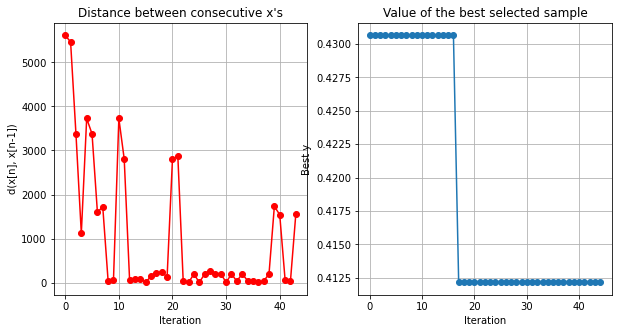

In [7]:
optimizer.plot_convergence()

In [8]:
[(bounds[i]['name'], optimum) for i, optimum in enumerate(optimizer.x_opt)]

[('learning_rate', 0.030150061167891054),
 ('n_layers', 4.0),
 ('layer_size', 128.0),
 ('batch_size', 256.0),
 ('nbits', 2048.0),
 ('radius', 6.0)]

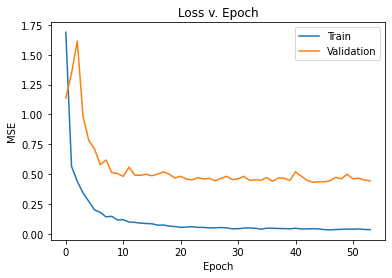

In [9]:
from matplotlib import pyplot as plt

plt.plot(best['history'].history['mse'], label='Train')
plt.plot(best['history'].history['val_mse'], label='Validation')

plt.title('Loss v. Epoch')
plt.ylabel('MSE')
plt.xlabel('Epoch')

plt.legend(loc='upper right')
plt.show()

In [10]:
best

{'score': 0.41215528299494153,
 'history': <tensorflow.python.keras.callbacks.History at 0x247192d7808>}